# Load data

In [1]:
import pandas as pd
from constants import NULLABLE_MEASURES
from utils.class_patient import Patients

patients = Patients.loadPatients()
patients.fillMissingMeasureValue(NULLABLE_MEASURES, 0)

# Remove missing data

## Remove features with more than 20% missing

In [2]:
# remove measures with less than 80% of data

measures = patients.getMeasures()

for measure, count in measures.items():
    if count < len(patients) * 80 / 100:
        patients.removeMeasures([measure])
        print(measure, count)

pco2 917
ph 954
po2 917
albumin 406
hba1c 326
lymphocyte 446
height 415
urine-ketone 294
crp 19


## Remove patients with more than 20% missing features

In [3]:
patients.removePatientByMissingFeatures()
len(patients)

1206

## Display insight

In [4]:
# dfData = patients.getMeasuresBetween(pd.Timedelta(hours=-6), pd.Timedelta(hours=24), "first")

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(patients.getMeasures())

Counter({'age': 1206,
         'chronic_pulmonary_disease': 1206,
         'ckd_stage': 1206,
         'congestive_heart_failure': 1206,
         'dka_type': 1206,
         'gender': 1206,
         'history_aci': 1206,
         'history_ami': 1206,
         'hypertension': 1206,
         'liver_disease': 1206,
         'macroangiopathy': 1206,
         'malignant_cancer': 1206,
         'mechanical_ventilation': 1206,
         'microangiopathy': 1206,
         'oasis': 1206,
         'preiculos': 1206,
         'race': 1206,
         'saps2': 1206,
         'sofa': 1206,
         'use_NaHCO3': 1206,
         'uti': 1206,
         'ag': 1205,
         'bg': 1205,
         'bicarbonate': 1205,
         'bun': 1205,
         'chloride': 1205,
         'egfr': 1205,
         'hr': 1205,
         'potassium': 1205,
         'scr': 1205,
         'sodium': 1205,
         'dbp': 1204,
         'gcs': 1204,
         'gcs_unable': 1204,
         'rr': 1204,
         'sbp': 1204,
         'calci

In [5]:
akdCount = sum([p.akdPositive for p in patients.patientList])

akdCount / len(patients)

0.39303482587064675

# Machine learning

In [6]:
from constants import CATEGORICAL_MEASURES


idColumns = ["subject_id", "hadm_id", "stay_id"]
categoryColumns = CATEGORICAL_MEASURES
labelColumn = "akd"

## Split train-test

In [7]:
splitedPatients = patients.split(5, 27)


def trainTest():
    for i in range(splitedPatients.__len__()):
        testPatients = splitedPatients[i]

        trainPatientsList = splitedPatients[:i] + splitedPatients[i + 1 :]
        trainPatients = Patients(patients=[])
        for trainPatientsElem in trainPatientsList:
            trainPatients += trainPatientsElem

        yield trainPatients, testPatients


def trainValTest():
    for i in range(splitedPatients.__len__()):
        testPatients = splitedPatients[i]

        trainPatientsList = splitedPatients[:i] + splitedPatients[i + 1 :]
        trainPatients = Patients(patients=[])
        for trainPatientsElem in trainPatientsList:
            trainPatients += trainPatientsElem

        *trainPatients, valPatients = trainPatients.split(5, 27)
        tmpPatients = Patients(patients=[])
        for trainPatientsElem in trainPatients:
            tmpPatients += trainPatientsElem
        trainPatients = tmpPatients

        yield trainPatients, valPatients, testPatients

## Define model

In [8]:
import xgboost as xgb

how = "first"

params = {
    "validate_parameters": True,
    "device": "gpu",  # Use GPU acceleration
    "n_jobs": -1,  # Use all CPU cores
    "eval_metric": "logloss",  # Evaluation metric
    "max_depth": 6,  # Maximum depth of a tree
    "min_child_weight": 1,  # Minimum sum of instance weight (hessian) needed in a child
    "gamma": 0,  # Minimum loss reduction required to make a further partition on a leaf node
    "subsample": 0.8,  # Subsample ratio of the training instances
    "colsample_bytree": 0.8,  # Subsample ratio of columns when constructing each tree
    "reg_alpha": 0.01,  # L1 regularization term on weights
    "reg_lambda": 1,  # L2 regularization term on weights
    "objective": "binary:logistic",  # Binary classification objective
    "n_estimators": 1000,  # Number of trees
    "learning_rate": 0.01,  # Learning rate
    "early_stopping_rounds": 10,  # Early stopping
    "verbose": 0,  # Verbosity
}


def createModel():
    model = xgb.XGBClassifier(**params)
    return model

`functionize-notebook` has modified this notebook during execution. The following variables have been injected:

- how: med


## Without validate

### Without fill missing data

In [10]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from utils.prepare_data import normalizeData


accuracy_score_list = []
precision_score_list = []
recall_score_list = []
auc_score_list = []
for trainPatients, testPatients in trainTest():
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, _ = normalizeData(dfTrain, dfTest)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    model = createModel()
    model.fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=False)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

    accuracy_score_list.append(accuracy_score(y_test, y_pred))
    precision_score_list.append(precision_score(y_test, y_pred))
    recall_score_list.append(recall_score(y_test, y_pred))
    auc_score_list.append(roc_auc_score(y_test, y_pred_proba))

/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:35:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:35:16] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:35:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:35:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:36:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:36:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


In [11]:

print(f"Average AUC: {np.mean(auc_score_list)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list)}")
print(f"Average Precision: {np.mean(precision_score_list)}")
print(f"Average Recall: {np.mean(recall_score_list)}")

Average AUC: 0.8278868508240247
Average Accuracy: 0.7636672267754878
Average Precision: 0.725293623355421
Average Recall: 0.6435162374020156


### Fill missing with knn

In [12]:
from sklearn.metrics import roc_auc_score
from utils.prepare_data import normalizeAndFillData


accuracy_score_list_knn = []
precision_score_list_knn = []
recall_score_list_knn = []
auc_score_list_knn = []
for trainPatients, testPatients in trainTest():
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, _ = normalizeAndFillData(dfTrain, dfTest)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    model = createModel()
    model.fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=False)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

    accuracy_score_list_knn.append(accuracy_score(y_test, y_pred))
    precision_score_list_knn.append(precision_score(y_test, y_pred))
    recall_score_list_knn.append(recall_score(y_test, y_pred))
    auc_score_list_knn.append(roc_auc_score(y_test, y_pred_proba))

/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:36:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:37:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:37:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:38:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:38:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


In [13]:

print(f"Average AUC: {np.mean(auc_score_list_knn)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list_knn)}")
print(f"Average Precision: {np.mean(precision_score_list_knn)}")
print(f"Average Recall: {np.mean(recall_score_list_knn)}")

Average AUC: 0.8106101306895919
Average Accuracy: 0.7495730599087823
Average Precision: 0.7148141961563669
Average Recall: 0.6055991041433371


## With validate

### Without fill missing data

In [14]:
from utils.prepare_data import normalizeData


accuracy_score_list_val = []
precision_score_list_val = []
recall_score_list_val = []
auc_score_list_val = []
for trainPatients, valPatients, testPatients in trainValTest():
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfVal = valPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfVal = dfVal.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, dfVal = normalizeData(dfTrain, dfTest, dfVal)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_val = dfVal.drop(columns=[labelColumn]) # type: ignore
    y_val = dfVal[labelColumn] # type: ignore

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    model = createModel()
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

    accuracy_score_list_val.append(accuracy_score(y_test, y_pred))
    precision_score_list_val.append(precision_score(y_test, y_pred))
    recall_score_list_val.append(recall_score(y_test, y_pred))
    auc_score_list_val.append(roc_auc_score(y_test, y_pred_proba))

[0]	validation_0-logloss:0.66587


[1]	validation_0-logloss:0.66277


[2]	validation_0-logloss:0.66040


[3]	validation_0-logloss:0.65806


[4]	validation_0-logloss:0.65489


[5]	validation_0-logloss:0.65240


[6]	validation_0-logloss:0.65020


[7]	validation_0-logloss:0.64767


[8]	validation_0-logloss:0.64512


[9]	validation_0-logloss:0.64279


[10]	validation_0-logloss:0.64006


[11]	validation_0-logloss:0.63780


[12]	validation_0-logloss:0.63560


[13]	validation_0-logloss:0.63351


[14]	validation_0-logloss:0.63130


[15]	validation_0-logloss:0.62920


[16]	validation_0-logloss:0.62654


[17]	validation_0-logloss:0.62403


[18]	validation_0-logloss:0.62224


[19]	validation_0-logloss:0.62021


[20]	validation_0-logloss:0.61855


[21]	validation_0-logloss:0.61684


[22]	validation_0-logloss:0.61516


[23]	validation_0-logloss:0.61392


[24]	validation_0-logloss:0.61254


[25]	validation_0-logloss:0.61071


[26]	validation_0-logloss:0.60930


[27]	validation_0-logloss:0.60734


[28]	validation_0-logloss:0.60613


[29]	validation_0-logloss:0.60421


[30]	validation_0-logloss:0.60252


[31]	validation_0-logloss:0.60107


[32]	validation_0-logloss:0.59941


[33]	validation_0-logloss:0.59748


[34]	validation_0-logloss:0.59573


[35]	validation_0-logloss:0.59408


[36]	validation_0-logloss:0.59240


[37]	validation_0-logloss:0.59103


[38]	validation_0-logloss:0.58992


[39]	validation_0-logloss:0.58866


[40]	validation_0-logloss:0.58721


[41]	validation_0-logloss:0.58661


[42]	validation_0-logloss:0.58547


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:38:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[43]	validation_0-logloss:0.58390


[44]	validation_0-logloss:0.58241


[45]	validation_0-logloss:0.58135


[46]	validation_0-logloss:0.58015


[47]	validation_0-logloss:0.57875


[48]	validation_0-logloss:0.57779


[49]	validation_0-logloss:0.57636

[50]	validation_0-logloss:0.57520


[51]	validation_0-logloss:0.57427


[52]	validation_0-logloss:0.57307


[53]	validation_0-logloss:0.57165


[54]	validation_0-logloss:0.57030


[55]	validation_0-logloss:0.56882


[56]	validation_0-logloss:0.56772


[57]	validation_0-logloss:0.56720


[58]	validation_0-logloss:0.56618


[59]	validation_0-logloss:0.56535


[60]	validation_0-logloss:0.56402


[61]	validation_0-logloss:0.56316


[62]	validation_0-logloss:0.56185


[63]	validation_0-logloss:0.56089


[64]	validation_0-logloss:0.55951


[65]	validation_0-logloss:0.55842


[66]	validation_0-logloss:0.55726


[67]	validation_0-logloss:0.55677


[68]	validation_0-logloss:0.55555


[69]	validation_0-logloss:0.55438


[70]	validation_0-logloss:0.55310


[71]	validation_0-logloss:0.55206


[72]	validation_0-logloss:0.55111


[73]	validation_0-logloss:0.54980


[74]	validation_0-logloss:0.54888


[75]	validation_0-logloss:0.54821


[76]	validation_0-logloss:0.54753


[77]	validation_0-logloss:0.54660


[78]	validation_0-logloss:0.54586


[79]	validation_0-logloss:0.54512


[80]	validation_0-logloss:0.54390


[81]	validation_0-logloss:0.54294


[82]	validation_0-logloss:0.54212


[83]	validation_0-logloss:0.54148


[84]	validation_0-logloss:0.54013


[85]	validation_0-logloss:0.53927


[86]	validation_0-logloss:0.53859


[87]	validation_0-logloss:0.53785


[88]	validation_0-logloss:0.53690


[89]	validation_0-logloss:0.53624


[90]	validation_0-logloss:0.53531


[91]	validation_0-logloss:0.53472


[92]	validation_0-logloss:0.53381


[93]	validation_0-logloss:0.53365


[94]	validation_0-logloss:0.53282


[95]	validation_0-logloss:0.53166


[96]	validation_0-logloss:0.53115


[97]	validation_0-logloss:0.53066


[98]	validation_0-logloss:0.53033


[99]	validation_0-logloss:0.52983


[100]	validation_0-logloss:0.52933


[101]	validation_0-logloss:0.52860


[102]	validation_0-logloss:0.52767


[103]	validation_0-logloss:0.52669


[104]	validation_0-logloss:0.52586

[105]	validation_0-logloss:0.52518


[106]	validation_0-logloss:0.52452


[107]	validation_0-logloss:0.52381


[108]	validation_0-logloss:0.52307


[109]	validation_0-logloss:0.52241


[110]	validation_0-logloss:0.52191


[111]	validation_0-logloss:0.52136


[112]	validation_0-logloss:0.52086


[113]	validation_0-logloss:0.52037


[114]	validation_0-logloss:0.51976


[115]	validation_0-logloss:0.51901


[116]	validation_0-logloss:0.51847


[117]	validation_0-logloss:0.51801


[118]	validation_0-logloss:0.51781


[119]	validation_0-logloss:0.51740


[120]	validation_0-logloss:0.51688


[121]	validation_0-logloss:0.51647


[122]	validation_0-logloss:0.51578


[123]	validation_0-logloss:0.51511


[124]	validation_0-logloss:0.51424


[125]	validation_0-logloss:0.51394


[126]	validation_0-logloss:0.51362


[127]	validation_0-logloss:0.51296


[128]	validation_0-logloss:0.51285


[129]	validation_0-logloss:0.51218


[130]	validation_0-logloss:0.51156


[131]	validation_0-logloss:0.51115


[132]	validation_0-logloss:0.51061

[133]	validation_0-logloss:0.51039


[134]	validation_0-logloss:0.51007


[135]	validation_0-logloss:0.50948


[136]	validation_0-logloss:0.50908

[137]	validation_0-logloss:0.50865

[138]	validation_0-logloss:0.50851

[139]	validation_0-logloss:0.50803


[140]	validation_0-logloss:0.50755


[141]	validation_0-logloss:0.50718


[142]	validation_0-logloss:0.50668

[143]	validation_0-logloss:0.50614


[144]	validation_0-logloss:0.50587


[145]	validation_0-logloss:0.50521


[146]	validation_0-logloss:0.50463


[147]	validation_0-logloss:0.50420


[148]	validation_0-logloss:0.50392


[149]	validation_0-logloss:0.50326


[150]	validation_0-logloss:0.50321


[151]	validation_0-logloss:0.50283


[152]	validation_0-logloss:0.50275


[153]	validation_0-logloss:0.50288


[154]	validation_0-logloss:0.50262


[155]	validation_0-logloss:0.50246


[156]	validation_0-logloss:0.50187


[157]	validation_0-logloss:0.50141


[158]	validation_0-logloss:0.50086


[159]	validation_0-logloss:0.50012


[160]	validation_0-logloss:0.49999


[161]	validation_0-logloss:0.49955


[162]	validation_0-logloss:0.49953


[163]	validation_0-logloss:0.49936


[164]	validation_0-logloss:0.49925


[165]	validation_0-logloss:0.49927


[166]	validation_0-logloss:0.49886


[167]	validation_0-logloss:0.49850


[168]	validation_0-logloss:0.49814


[169]	validation_0-logloss:0.49814


[170]	validation_0-logloss:0.49786


[171]	validation_0-logloss:0.49769


[172]	validation_0-logloss:0.49747


[173]	validation_0-logloss:0.49725


[174]	validation_0-logloss:0.49745


[175]	validation_0-logloss:0.49750


[176]	validation_0-logloss:0.49721


[177]	validation_0-logloss:0.49664


[178]	validation_0-logloss:0.49628


[179]	validation_0-logloss:0.49615


[180]	validation_0-logloss:0.49571


[181]	validation_0-logloss:0.49557


[182]	validation_0-logloss:0.49551


[183]	validation_0-logloss:0.49516


[184]	validation_0-logloss:0.49506


[185]	validation_0-logloss:0.49486


[186]	validation_0-logloss:0.49427


[187]	validation_0-logloss:0.49438


[188]	validation_0-logloss:0.49385


[189]	validation_0-logloss:0.49347


[190]	validation_0-logloss:0.49307


[191]	validation_0-logloss:0.49279


[192]	validation_0-logloss:0.49281


[193]	validation_0-logloss:0.49238


[194]	validation_0-logloss:0.49181


[195]	validation_0-logloss:0.49144


[196]	validation_0-logloss:0.49116


[197]	validation_0-logloss:0.49133


[198]	validation_0-logloss:0.49119


[199]	validation_0-logloss:0.49113


[200]	validation_0-logloss:0.49135

[201]	validation_0-logloss:0.49077


[202]	validation_0-logloss:0.49061


[203]	validation_0-logloss:0.49060


[204]	validation_0-logloss:0.49041


[205]	validation_0-logloss:0.49029


[206]	validation_0-logloss:0.49037


[207]	validation_0-logloss:0.49020


[208]	validation_0-logloss:0.49013


[209]	validation_0-logloss:0.49016


[210]	validation_0-logloss:0.49038


[211]	validation_0-logloss:0.49048


[212]	validation_0-logloss:0.49022


[213]	validation_0-logloss:0.49006


[214]	validation_0-logloss:0.48997


[215]	validation_0-logloss:0.48987


[216]	validation_0-logloss:0.48991


[217]	validation_0-logloss:0.48987


[218]	validation_0-logloss:0.48966


[219]	validation_0-logloss:0.48896


[220]	validation_0-logloss:0.48905


[221]	validation_0-logloss:0.48903


[222]	validation_0-logloss:0.48875


[223]	validation_0-logloss:0.48868


[224]	validation_0-logloss:0.48890


[225]	validation_0-logloss:0.48884


[226]	validation_0-logloss:0.48853


[227]	validation_0-logloss:0.48866


[228]	validation_0-logloss:0.48819


[229]	validation_0-logloss:0.48769


[230]	validation_0-logloss:0.48727


[231]	validation_0-logloss:0.48722


[232]	validation_0-logloss:0.48703


[233]	validation_0-logloss:0.48696


[234]	validation_0-logloss:0.48673


[235]	validation_0-logloss:0.48637


[236]	validation_0-logloss:0.48629


[237]	validation_0-logloss:0.48607


[238]	validation_0-logloss:0.48589


[239]	validation_0-logloss:0.48606


[240]	validation_0-logloss:0.48602


[241]	validation_0-logloss:0.48621


[242]	validation_0-logloss:0.48636


[243]	validation_0-logloss:0.48626


[244]	validation_0-logloss:0.48611

[245]	validation_0-logloss:0.48596


[246]	validation_0-logloss:0.48600


[247]	validation_0-logloss:0.48603


[248]	validation_0-logloss:0.48596

[0]	validation_0-logloss:0.66781


[1]	validation_0-logloss:0.66525


[2]	validation_0-logloss:0.66263


[3]	validation_0-logloss:0.65996


[4]	validation_0-logloss:0.65721


[5]	validation_0-logloss:0.65471


[6]	validation_0-logloss:0.65135


[7]	validation_0-logloss:0.64926


[8]	validation_0-logloss:0.64711


[9]	validation_0-logloss:0.64512


[10]	validation_0-logloss:0.64317


[11]	validation_0-logloss:0.64102


[12]	validation_0-logloss:0.63912


[13]	validation_0-logloss:0.63749


[14]	validation_0-logloss:0.63480


[15]	validation_0-logloss:0.63265


[16]	validation_0-logloss:0.63073


[17]	validation_0-logloss:0.62864


[18]	validation_0-logloss:0.62704


[19]	validation_0-logloss:0.62527


[20]	validation_0-logloss:0.62351


[21]	validation_0-logloss:0.62149


[22]	validation_0-logloss:0.61941


[23]	validation_0-logloss:0.61770


[24]	validation_0-logloss:0.61579


[25]	validation_0-logloss:0.61394


[26]	validation_0-logloss:0.61262


[27]	validation_0-logloss:0.61135


[28]	validation_0-logloss:0.60995


[29]	validation_0-logloss:0.60841


[30]	validation_0-logloss:0.60732


[31]	validation_0-logloss:0.60615


[32]	validation_0-logloss:0.60472


[33]	validation_0-logloss:0.60346


[34]	validation_0-logloss:0.60139


[35]	validation_0-logloss:0.59975


[36]	validation_0-logloss:0.59823


[37]	validation_0-logloss:0.59677


[38]	validation_0-logloss:0.59505


[39]	validation_0-logloss:0.59337


[40]	validation_0-logloss:0.59224


[41]	validation_0-logloss:0.59107


[42]	validation_0-logloss:0.58979


[43]	validation_0-logloss:0.58850


[44]	validation_0-logloss:0.58676


[45]	validation_0-logloss:0.58567


[46]	validation_0-logloss:0.58438


[47]	validation_0-logloss:0.58363


[48]	validation_0-logloss:0.58241


[49]	validation_0-logloss:0.58113


[50]	validation_0-logloss:0.57977


[51]	validation_0-logloss:0.57875


[52]	validation_0-logloss:0.57775


[53]	validation_0-logloss:0.57657


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:39:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[54]	validation_0-logloss:0.57556


[55]	validation_0-logloss:0.57430


[56]	validation_0-logloss:0.57301


[57]	validation_0-logloss:0.57184


[58]	validation_0-logloss:0.57077


[59]	validation_0-logloss:0.56964


[60]	validation_0-logloss:0.56868


[61]	validation_0-logloss:0.56798


[62]	validation_0-logloss:0.56699


[63]	validation_0-logloss:0.56567


[64]	validation_0-logloss:0.56501


[65]	validation_0-logloss:0.56389


[66]	validation_0-logloss:0.56278


[67]	validation_0-logloss:0.56162


[68]	validation_0-logloss:0.56054


[69]	validation_0-logloss:0.55934


[70]	validation_0-logloss:0.55798


[71]	validation_0-logloss:0.55684


[72]	validation_0-logloss:0.55599

[73]	validation_0-logloss:0.55471

[74]	validation_0-logloss:0.55394

[75]	validation_0-logloss:0.55332

[76]	validation_0-logloss:0.55272

[77]	validation_0-logloss:0.55177


[78]	validation_0-logloss:0.55087


[79]	validation_0-logloss:0.54993


[80]	validation_0-logloss:0.54928


[81]	validation_0-logloss:0.54855


[82]	validation_0-logloss:0.54787


[83]	validation_0-logloss:0.54640


[84]	validation_0-logloss:0.54586


[85]	validation_0-logloss:0.54539


[86]	validation_0-logloss:0.54470


[87]	validation_0-logloss:0.54372


[88]	validation_0-logloss:0.54286


[89]	validation_0-logloss:0.54267


[90]	validation_0-logloss:0.54172


[91]	validation_0-logloss:0.54180


[92]	validation_0-logloss:0.54155


[93]	validation_0-logloss:0.54084


[94]	validation_0-logloss:0.53991


[95]	validation_0-logloss:0.53937


[96]	validation_0-logloss:0.53918


[97]	validation_0-logloss:0.53835


[98]	validation_0-logloss:0.53782


[99]	validation_0-logloss:0.53717


[100]	validation_0-logloss:0.53673


[101]	validation_0-logloss:0.53623


[102]	validation_0-logloss:0.53527


[103]	validation_0-logloss:0.53476


[104]	validation_0-logloss:0.53416


[105]	validation_0-logloss:0.53377


[106]	validation_0-logloss:0.53323


[107]	validation_0-logloss:0.53270


[108]	validation_0-logloss:0.53202


[109]	validation_0-logloss:0.53121


[110]	validation_0-logloss:0.53124


[111]	validation_0-logloss:0.53050


[112]	validation_0-logloss:0.52986

[113]	validation_0-logloss:0.52956

[114]	validation_0-logloss:0.52905


[115]	validation_0-logloss:0.52899


[116]	validation_0-logloss:0.52834


[117]	validation_0-logloss:0.52782


[118]	validation_0-logloss:0.52717


[119]	validation_0-logloss:0.52673

[120]	validation_0-logloss:0.52623


[121]	validation_0-logloss:0.52585


[122]	validation_0-logloss:0.52539


[123]	validation_0-logloss:0.52504


[124]	validation_0-logloss:0.52451


[125]	validation_0-logloss:0.52400


[126]	validation_0-logloss:0.52345


[127]	validation_0-logloss:0.52300


[128]	validation_0-logloss:0.52242


[129]	validation_0-logloss:0.52248


[130]	validation_0-logloss:0.52252


[131]	validation_0-logloss:0.52219

[132]	validation_0-logloss:0.52121


[133]	validation_0-logloss:0.52090


[134]	validation_0-logloss:0.52058


[135]	validation_0-logloss:0.51999


[136]	validation_0-logloss:0.51926


[137]	validation_0-logloss:0.51894


[138]	validation_0-logloss:0.51852


[139]	validation_0-logloss:0.51826


[140]	validation_0-logloss:0.51808


[141]	validation_0-logloss:0.51770


[142]	validation_0-logloss:0.51704


[143]	validation_0-logloss:0.51676


[144]	validation_0-logloss:0.51652


[145]	validation_0-logloss:0.51632


[146]	validation_0-logloss:0.51605


[147]	validation_0-logloss:0.51614


[148]	validation_0-logloss:0.51598


[149]	validation_0-logloss:0.51562


[150]	validation_0-logloss:0.51527


[151]	validation_0-logloss:0.51508


[152]	validation_0-logloss:0.51455


[153]	validation_0-logloss:0.51417


[154]	validation_0-logloss:0.51398


[155]	validation_0-logloss:0.51372


[156]	validation_0-logloss:0.51333


[157]	validation_0-logloss:0.51298


[158]	validation_0-logloss:0.51292


[159]	validation_0-logloss:0.51259


[160]	validation_0-logloss:0.51247


[161]	validation_0-logloss:0.51225


[162]	validation_0-logloss:0.51192


[163]	validation_0-logloss:0.51191


[164]	validation_0-logloss:0.51173


[165]	validation_0-logloss:0.51138


[166]	validation_0-logloss:0.51111


[167]	validation_0-logloss:0.51112


[168]	validation_0-logloss:0.51093


[169]	validation_0-logloss:0.51020


[170]	validation_0-logloss:0.51006


[171]	validation_0-logloss:0.50993


[172]	validation_0-logloss:0.50986


[173]	validation_0-logloss:0.50967


[174]	validation_0-logloss:0.50953


[175]	validation_0-logloss:0.50944


[176]	validation_0-logloss:0.50953


[177]	validation_0-logloss:0.50922

[178]	validation_0-logloss:0.50894

[179]	validation_0-logloss:0.50846


[180]	validation_0-logloss:0.50797


[181]	validation_0-logloss:0.50805


[182]	validation_0-logloss:0.50784


[183]	validation_0-logloss:0.50773


[184]	validation_0-logloss:0.50746


[185]	validation_0-logloss:0.50739


[186]	validation_0-logloss:0.50691


[187]	validation_0-logloss:0.50678


[188]	validation_0-logloss:0.50662


[189]	validation_0-logloss:0.50624


[190]	validation_0-logloss:0.50625


[191]	validation_0-logloss:0.50592


[192]	validation_0-logloss:0.50539


[193]	validation_0-logloss:0.50520


[194]	validation_0-logloss:0.50510


[195]	validation_0-logloss:0.50487


[196]	validation_0-logloss:0.50488


[197]	validation_0-logloss:0.50484


[198]	validation_0-logloss:0.50479


[199]	validation_0-logloss:0.50461


[200]	validation_0-logloss:0.50470


[201]	validation_0-logloss:0.50455


[202]	validation_0-logloss:0.50426


[203]	validation_0-logloss:0.50425


[204]	validation_0-logloss:0.50441


[205]	validation_0-logloss:0.50424


[206]	validation_0-logloss:0.50425


[207]	validation_0-logloss:0.50416


[208]	validation_0-logloss:0.50417


[209]	validation_0-logloss:0.50419


[210]	validation_0-logloss:0.50421


[211]	validation_0-logloss:0.50390


[212]	validation_0-logloss:0.50383


[213]	validation_0-logloss:0.50366


[214]	validation_0-logloss:0.50334


[215]	validation_0-logloss:0.50296


[216]	validation_0-logloss:0.50276


[217]	validation_0-logloss:0.50261


[218]	validation_0-logloss:0.50265


[219]	validation_0-logloss:0.50256


[220]	validation_0-logloss:0.50267


[221]	validation_0-logloss:0.50259


[222]	validation_0-logloss:0.50210


[223]	validation_0-logloss:0.50197


[224]	validation_0-logloss:0.50192


[225]	validation_0-logloss:0.50202


[226]	validation_0-logloss:0.50183


[227]	validation_0-logloss:0.50173


[228]	validation_0-logloss:0.50177


[229]	validation_0-logloss:0.50174


[230]	validation_0-logloss:0.50154


[231]	validation_0-logloss:0.50152


[232]	validation_0-logloss:0.50135


[233]	validation_0-logloss:0.50111


[234]	validation_0-logloss:0.50120


[235]	validation_0-logloss:0.50077


[236]	validation_0-logloss:0.50060


[237]	validation_0-logloss:0.50068


[238]	validation_0-logloss:0.50056


[239]	validation_0-logloss:0.50073


[240]	validation_0-logloss:0.50076


[241]	validation_0-logloss:0.50110


[242]	validation_0-logloss:0.50104


[243]	validation_0-logloss:0.50072


[244]	validation_0-logloss:0.50070


[245]	validation_0-logloss:0.50074


[246]	validation_0-logloss:0.50061


[247]	validation_0-logloss:0.50049


[248]	validation_0-logloss:0.50040


[249]	validation_0-logloss:0.50018


[250]	validation_0-logloss:0.50019


[251]	validation_0-logloss:0.50007


[252]	validation_0-logloss:0.50002


[253]	validation_0-logloss:0.50030


[254]	validation_0-logloss:0.50029

[255]	validation_0-logloss:0.50015


[256]	validation_0-logloss:0.49991


[257]	validation_0-logloss:0.49991


[258]	validation_0-logloss:0.49953


[259]	validation_0-logloss:0.49943


[260]	validation_0-logloss:0.49904


[261]	validation_0-logloss:0.49906


[262]	validation_0-logloss:0.49912


[263]	validation_0-logloss:0.49897


[264]	validation_0-logloss:0.49917


[265]	validation_0-logloss:0.49925


[266]	validation_0-logloss:0.49940


[267]	validation_0-logloss:0.49932


[268]	validation_0-logloss:0.49904


[269]	validation_0-logloss:0.49912


[270]	validation_0-logloss:0.49935


[271]	validation_0-logloss:0.49922

[272]	validation_0-logloss:0.49935


[0]	validation_0-logloss:0.66793


[1]	validation_0-logloss:0.66575


[2]	validation_0-logloss:0.66339


[3]	validation_0-logloss:0.66255


[4]	validation_0-logloss:0.66146


[5]	validation_0-logloss:0.65993


[6]	validation_0-logloss:0.65774


[7]	validation_0-logloss:0.65619


[8]	validation_0-logloss:0.65417


[9]	validation_0-logloss:0.65218


[10]	validation_0-logloss:0.65059


[11]	validation_0-logloss:0.64863


[12]	validation_0-logloss:0.64700


[13]	validation_0-logloss:0.64492


[14]	validation_0-logloss:0.64238


[15]	validation_0-logloss:0.64075


[16]	validation_0-logloss:0.63957


[17]	validation_0-logloss:0.63738


[18]	validation_0-logloss:0.63607


[19]	validation_0-logloss:0.63479


[20]	validation_0-logloss:0.63355


[21]	validation_0-logloss:0.63184


[22]	validation_0-logloss:0.63055


[23]	validation_0-logloss:0.62864


[24]	validation_0-logloss:0.62763


[25]	validation_0-logloss:0.62597


[26]	validation_0-logloss:0.62442


[27]	validation_0-logloss:0.62313


[28]	validation_0-logloss:0.62233


[29]	validation_0-logloss:0.62115


[30]	validation_0-logloss:0.61991


[31]	validation_0-logloss:0.61912


[32]	validation_0-logloss:0.61765


[33]	validation_0-logloss:0.61648


[34]	validation_0-logloss:0.61534


[35]	validation_0-logloss:0.61375


[36]	validation_0-logloss:0.61239


[37]	validation_0-logloss:0.61143


[38]	validation_0-logloss:0.61035


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:39:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[39]	validation_0-logloss:0.60949


[40]	validation_0-logloss:0.60776


[41]	validation_0-logloss:0.60642


[42]	validation_0-logloss:0.60571


[43]	validation_0-logloss:0.60466


[44]	validation_0-logloss:0.60331


[45]	validation_0-logloss:0.60254


[46]	validation_0-logloss:0.60199


[47]	validation_0-logloss:0.60111


[48]	validation_0-logloss:0.59999


[49]	validation_0-logloss:0.59881


[50]	validation_0-logloss:0.59763


[51]	validation_0-logloss:0.59659


[52]	validation_0-logloss:0.59609


[53]	validation_0-logloss:0.59487


[54]	validation_0-logloss:0.59418


[55]	validation_0-logloss:0.59306


[56]	validation_0-logloss:0.59203


[57]	validation_0-logloss:0.59144


[58]	validation_0-logloss:0.59075


[59]	validation_0-logloss:0.58999


[60]	validation_0-logloss:0.58922


[61]	validation_0-logloss:0.58837


[62]	validation_0-logloss:0.58746

[63]	validation_0-logloss:0.58641


[64]	validation_0-logloss:0.58591


[65]	validation_0-logloss:0.58486


[66]	validation_0-logloss:0.58425


[67]	validation_0-logloss:0.58354


[68]	validation_0-logloss:0.58311


[69]	validation_0-logloss:0.58221


[70]	validation_0-logloss:0.58131


[71]	validation_0-logloss:0.58082


[72]	validation_0-logloss:0.57974


[73]	validation_0-logloss:0.57866


[74]	validation_0-logloss:0.57752


[75]	validation_0-logloss:0.57665


[76]	validation_0-logloss:0.57615


[77]	validation_0-logloss:0.57568


[78]	validation_0-logloss:0.57510


[79]	validation_0-logloss:0.57437


[80]	validation_0-logloss:0.57361


[81]	validation_0-logloss:0.57320


[82]	validation_0-logloss:0.57279


[83]	validation_0-logloss:0.57241


[84]	validation_0-logloss:0.57190


[85]	validation_0-logloss:0.57140


[86]	validation_0-logloss:0.57059

[87]	validation_0-logloss:0.57014


[88]	validation_0-logloss:0.56978

[89]	validation_0-logloss:0.57000

[90]	validation_0-logloss:0.56947


[91]	validation_0-logloss:0.56894


[92]	validation_0-logloss:0.56800


[93]	validation_0-logloss:0.56703

[94]	validation_0-logloss:0.56659


[95]	validation_0-logloss:0.56611


[96]	validation_0-logloss:0.56592


[97]	validation_0-logloss:0.56531


[98]	validation_0-logloss:0.56464


[99]	validation_0-logloss:0.56428


[100]	validation_0-logloss:0.56424

[101]	validation_0-logloss:0.56386

[102]	validation_0-logloss:0.56338


[103]	validation_0-logloss:0.56266


[104]	validation_0-logloss:0.56182


[105]	validation_0-logloss:0.56175


[106]	validation_0-logloss:0.56134


[107]	validation_0-logloss:0.56122


[108]	validation_0-logloss:0.56051


[109]	validation_0-logloss:0.55963


[110]	validation_0-logloss:0.55977


[111]	validation_0-logloss:0.55998


[112]	validation_0-logloss:0.55943


[113]	validation_0-logloss:0.55864


[114]	validation_0-logloss:0.55821


[115]	validation_0-logloss:0.55784


[116]	validation_0-logloss:0.55746


[117]	validation_0-logloss:0.55697


[118]	validation_0-logloss:0.55592


[119]	validation_0-logloss:0.55518


[120]	validation_0-logloss:0.55458


[121]	validation_0-logloss:0.55387


[122]	validation_0-logloss:0.55374


[123]	validation_0-logloss:0.55322


[124]	validation_0-logloss:0.55259


[125]	validation_0-logloss:0.55203


[126]	validation_0-logloss:0.55151


[127]	validation_0-logloss:0.55101


[128]	validation_0-logloss:0.55020


[129]	validation_0-logloss:0.54990


[130]	validation_0-logloss:0.54972


[131]	validation_0-logloss:0.54944


[132]	validation_0-logloss:0.54935


[133]	validation_0-logloss:0.54880


[134]	validation_0-logloss:0.54871


[135]	validation_0-logloss:0.54833


[136]	validation_0-logloss:0.54810


[137]	validation_0-logloss:0.54773


[138]	validation_0-logloss:0.54749


[139]	validation_0-logloss:0.54697


[140]	validation_0-logloss:0.54671


[141]	validation_0-logloss:0.54639


[142]	validation_0-logloss:0.54637


[143]	validation_0-logloss:0.54587

[144]	validation_0-logloss:0.54566


[145]	validation_0-logloss:0.54532


[146]	validation_0-logloss:0.54468


[147]	validation_0-logloss:0.54441


[148]	validation_0-logloss:0.54395


[149]	validation_0-logloss:0.54332


[150]	validation_0-logloss:0.54355


[151]	validation_0-logloss:0.54307


[152]	validation_0-logloss:0.54274


[153]	validation_0-logloss:0.54272


[154]	validation_0-logloss:0.54227


[155]	validation_0-logloss:0.54202


[156]	validation_0-logloss:0.54173


[157]	validation_0-logloss:0.54117


[158]	validation_0-logloss:0.54127


[159]	validation_0-logloss:0.54099


[160]	validation_0-logloss:0.54063


[161]	validation_0-logloss:0.54015


[162]	validation_0-logloss:0.53980


[163]	validation_0-logloss:0.53969


[164]	validation_0-logloss:0.53949


[165]	validation_0-logloss:0.53893


[166]	validation_0-logloss:0.53867


[167]	validation_0-logloss:0.53797


[168]	validation_0-logloss:0.53789


[169]	validation_0-logloss:0.53795


[170]	validation_0-logloss:0.53765


[171]	validation_0-logloss:0.53749


[172]	validation_0-logloss:0.53695


[173]	validation_0-logloss:0.53644


[174]	validation_0-logloss:0.53638


[175]	validation_0-logloss:0.53622


[176]	validation_0-logloss:0.53618


[177]	validation_0-logloss:0.53601


[178]	validation_0-logloss:0.53581


[179]	validation_0-logloss:0.53603


[180]	validation_0-logloss:0.53596


[181]	validation_0-logloss:0.53619


[182]	validation_0-logloss:0.53579


[183]	validation_0-logloss:0.53548


[184]	validation_0-logloss:0.53547


[185]	validation_0-logloss:0.53552


[186]	validation_0-logloss:0.53548


[187]	validation_0-logloss:0.53496


[188]	validation_0-logloss:0.53509

[189]	validation_0-logloss:0.53488


[190]	validation_0-logloss:0.53441

[191]	validation_0-logloss:0.53422


[192]	validation_0-logloss:0.53432


[193]	validation_0-logloss:0.53430


[194]	validation_0-logloss:0.53399


[195]	validation_0-logloss:0.53397


[196]	validation_0-logloss:0.53389


[197]	validation_0-logloss:0.53394


[198]	validation_0-logloss:0.53412


[199]	validation_0-logloss:0.53414


[200]	validation_0-logloss:0.53379


[201]	validation_0-logloss:0.53332


[202]	validation_0-logloss:0.53269

[203]	validation_0-logloss:0.53246


[204]	validation_0-logloss:0.53283


[205]	validation_0-logloss:0.53261


[206]	validation_0-logloss:0.53264


[207]	validation_0-logloss:0.53253


[208]	validation_0-logloss:0.53220


[209]	validation_0-logloss:0.53235


[210]	validation_0-logloss:0.53227


[211]	validation_0-logloss:0.53217


[212]	validation_0-logloss:0.53191


[213]	validation_0-logloss:0.53226


[214]	validation_0-logloss:0.53252


[215]	validation_0-logloss:0.53210


[216]	validation_0-logloss:0.53215


[217]	validation_0-logloss:0.53171


[218]	validation_0-logloss:0.53166


[219]	validation_0-logloss:0.53177


[220]	validation_0-logloss:0.53154


[221]	validation_0-logloss:0.53120


[222]	validation_0-logloss:0.53130


[223]	validation_0-logloss:0.53106


[224]	validation_0-logloss:0.53071


[225]	validation_0-logloss:0.53020


[226]	validation_0-logloss:0.53014


[227]	validation_0-logloss:0.53019


[228]	validation_0-logloss:0.52996


[229]	validation_0-logloss:0.53014


[230]	validation_0-logloss:0.52991


[231]	validation_0-logloss:0.52958


[232]	validation_0-logloss:0.52981


[233]	validation_0-logloss:0.52984


[234]	validation_0-logloss:0.52956

[235]	validation_0-logloss:0.52967


[236]	validation_0-logloss:0.52962


[237]	validation_0-logloss:0.52971


[238]	validation_0-logloss:0.52969


[239]	validation_0-logloss:0.52954


[240]	validation_0-logloss:0.52940


[241]	validation_0-logloss:0.52946


[242]	validation_0-logloss:0.52924


[243]	validation_0-logloss:0.52922


[244]	validation_0-logloss:0.52921


[245]	validation_0-logloss:0.52911


[246]	validation_0-logloss:0.52881


[247]	validation_0-logloss:0.52866


[248]	validation_0-logloss:0.52836


[249]	validation_0-logloss:0.52835


[250]	validation_0-logloss:0.52841


[251]	validation_0-logloss:0.52852


[252]	validation_0-logloss:0.52831


[253]	validation_0-logloss:0.52867


[254]	validation_0-logloss:0.52882


[255]	validation_0-logloss:0.52854


[256]	validation_0-logloss:0.52836


[257]	validation_0-logloss:0.52823

[258]	validation_0-logloss:0.52835


[259]	validation_0-logloss:0.52822


[260]	validation_0-logloss:0.52826


[261]	validation_0-logloss:0.52822


[262]	validation_0-logloss:0.52817


[263]	validation_0-logloss:0.52802


[264]	validation_0-logloss:0.52783


[265]	validation_0-logloss:0.52766


[266]	validation_0-logloss:0.52786


[267]	validation_0-logloss:0.52748


[268]	validation_0-logloss:0.52741


[269]	validation_0-logloss:0.52750


[270]	validation_0-logloss:0.52751


[271]	validation_0-logloss:0.52736

[272]	validation_0-logloss:0.52743


[273]	validation_0-logloss:0.52713


[274]	validation_0-logloss:0.52661


[275]	validation_0-logloss:0.52686


[276]	validation_0-logloss:0.52705


[277]	validation_0-logloss:0.52698


[278]	validation_0-logloss:0.52686

[279]	validation_0-logloss:0.52690


[280]	validation_0-logloss:0.52686


[281]	validation_0-logloss:0.52703


[282]	validation_0-logloss:0.52710


[283]	validation_0-logloss:0.52708


[0]	validation_0-logloss:0.66821


[1]	validation_0-logloss:0.66552


[2]	validation_0-logloss:0.66332


[3]	validation_0-logloss:0.66165


[4]	validation_0-logloss:0.65912


[5]	validation_0-logloss:0.65746


[6]	validation_0-logloss:0.65574


[7]	validation_0-logloss:0.65358


[8]	validation_0-logloss:0.65163


[9]	validation_0-logloss:0.65007


[10]	validation_0-logloss:0.64848


[11]	validation_0-logloss:0.64680


[12]	validation_0-logloss:0.64483


[13]	validation_0-logloss:0.64238


[14]	validation_0-logloss:0.64010


[15]	validation_0-logloss:0.63834


[16]	validation_0-logloss:0.63694


[17]	validation_0-logloss:0.63472


[18]	validation_0-logloss:0.63310


[19]	validation_0-logloss:0.63146


[20]	validation_0-logloss:0.63003


[21]	validation_0-logloss:0.62910


[22]	validation_0-logloss:0.62777


[23]	validation_0-logloss:0.62641


[24]	validation_0-logloss:0.62469


[25]	validation_0-logloss:0.62304


[26]	validation_0-logloss:0.62159


[27]	validation_0-logloss:0.62020


[28]	validation_0-logloss:0.61853


[29]	validation_0-logloss:0.61735


[30]	validation_0-logloss:0.61568


[31]	validation_0-logloss:0.61399


[32]	validation_0-logloss:0.61295


[33]	validation_0-logloss:0.61115


[34]	validation_0-logloss:0.60942


[35]	validation_0-logloss:0.60769


[36]	validation_0-logloss:0.60564


[37]	validation_0-logloss:0.60436


[38]	validation_0-logloss:0.60360


[39]	validation_0-logloss:0.60320


[40]	validation_0-logloss:0.60226


[41]	validation_0-logloss:0.60110


[42]	validation_0-logloss:0.59980


[43]	validation_0-logloss:0.59894


[44]	validation_0-logloss:0.59803


[45]	validation_0-logloss:0.59656


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:39:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[46]	validation_0-logloss:0.59524


[47]	validation_0-logloss:0.59441


[48]	validation_0-logloss:0.59343


[49]	validation_0-logloss:0.59221


[50]	validation_0-logloss:0.59117


[51]	validation_0-logloss:0.59004


[52]	validation_0-logloss:0.58928


[53]	validation_0-logloss:0.58818


[54]	validation_0-logloss:0.58764


[55]	validation_0-logloss:0.58615


[56]	validation_0-logloss:0.58496


[57]	validation_0-logloss:0.58415


[58]	validation_0-logloss:0.58311


[59]	validation_0-logloss:0.58255


[60]	validation_0-logloss:0.58118


[61]	validation_0-logloss:0.58022


[62]	validation_0-logloss:0.57881


[63]	validation_0-logloss:0.57840


[64]	validation_0-logloss:0.57738


[65]	validation_0-logloss:0.57665


[66]	validation_0-logloss:0.57598


[67]	validation_0-logloss:0.57530


[68]	validation_0-logloss:0.57440

[69]	validation_0-logloss:0.57361


[70]	validation_0-logloss:0.57301


[71]	validation_0-logloss:0.57241

[72]	validation_0-logloss:0.57157


[73]	validation_0-logloss:0.57063


[74]	validation_0-logloss:0.56965


[75]	validation_0-logloss:0.56885


[76]	validation_0-logloss:0.56821

[77]	validation_0-logloss:0.56736


[78]	validation_0-logloss:0.56602


[79]	validation_0-logloss:0.56524


[80]	validation_0-logloss:0.56421


[81]	validation_0-logloss:0.56356


[82]	validation_0-logloss:0.56290


[83]	validation_0-logloss:0.56228


[84]	validation_0-logloss:0.56155

[85]	validation_0-logloss:0.56067

[86]	validation_0-logloss:0.55986


[87]	validation_0-logloss:0.55926


[88]	validation_0-logloss:0.55866


[89]	validation_0-logloss:0.55826

[90]	validation_0-logloss:0.55772


[91]	validation_0-logloss:0.55713


[92]	validation_0-logloss:0.55663


[93]	validation_0-logloss:0.55616


[94]	validation_0-logloss:0.55547


[95]	validation_0-logloss:0.55476


[96]	validation_0-logloss:0.55387

[97]	validation_0-logloss:0.55356


[98]	validation_0-logloss:0.55323


[99]	validation_0-logloss:0.55267


[100]	validation_0-logloss:0.55201


[101]	validation_0-logloss:0.55144


[102]	validation_0-logloss:0.55119


[103]	validation_0-logloss:0.55096

[104]	validation_0-logloss:0.55035


[105]	validation_0-logloss:0.55006


[106]	validation_0-logloss:0.54927


[107]	validation_0-logloss:0.54906

[108]	validation_0-logloss:0.54845


[109]	validation_0-logloss:0.54820


[110]	validation_0-logloss:0.54769


[111]	validation_0-logloss:0.54701


[112]	validation_0-logloss:0.54643


[113]	validation_0-logloss:0.54652


[114]	validation_0-logloss:0.54576


[115]	validation_0-logloss:0.54556


[116]	validation_0-logloss:0.54505


[117]	validation_0-logloss:0.54509


[118]	validation_0-logloss:0.54431


[119]	validation_0-logloss:0.54394


[120]	validation_0-logloss:0.54318


[121]	validation_0-logloss:0.54288


[122]	validation_0-logloss:0.54216


[123]	validation_0-logloss:0.54193


[124]	validation_0-logloss:0.54140


[125]	validation_0-logloss:0.54135


[126]	validation_0-logloss:0.54084


[127]	validation_0-logloss:0.54016


[128]	validation_0-logloss:0.53940


[129]	validation_0-logloss:0.53918


[130]	validation_0-logloss:0.53926


[131]	validation_0-logloss:0.53892


[132]	validation_0-logloss:0.53830


[133]	validation_0-logloss:0.53817


[134]	validation_0-logloss:0.53806


[135]	validation_0-logloss:0.53772


[136]	validation_0-logloss:0.53734


[137]	validation_0-logloss:0.53688


[138]	validation_0-logloss:0.53635


[139]	validation_0-logloss:0.53610


[140]	validation_0-logloss:0.53573


[141]	validation_0-logloss:0.53595


[142]	validation_0-logloss:0.53550


[143]	validation_0-logloss:0.53490


[144]	validation_0-logloss:0.53466


[145]	validation_0-logloss:0.53458


[146]	validation_0-logloss:0.53404


[147]	validation_0-logloss:0.53358


[148]	validation_0-logloss:0.53278


[149]	validation_0-logloss:0.53264


[150]	validation_0-logloss:0.53231


[151]	validation_0-logloss:0.53164

[152]	validation_0-logloss:0.53113


[153]	validation_0-logloss:0.53063


[154]	validation_0-logloss:0.53065


[155]	validation_0-logloss:0.53015


[156]	validation_0-logloss:0.52965

[157]	validation_0-logloss:0.52974


[158]	validation_0-logloss:0.52945


[159]	validation_0-logloss:0.52872


[160]	validation_0-logloss:0.52835


[161]	validation_0-logloss:0.52824


[162]	validation_0-logloss:0.52785


[163]	validation_0-logloss:0.52737


[164]	validation_0-logloss:0.52708


[165]	validation_0-logloss:0.52700


[166]	validation_0-logloss:0.52643


[167]	validation_0-logloss:0.52579


[168]	validation_0-logloss:0.52597


[169]	validation_0-logloss:0.52593


[170]	validation_0-logloss:0.52559


[171]	validation_0-logloss:0.52543


[172]	validation_0-logloss:0.52553


[173]	validation_0-logloss:0.52510


[174]	validation_0-logloss:0.52471


[175]	validation_0-logloss:0.52463


[176]	validation_0-logloss:0.52437


[177]	validation_0-logloss:0.52411


[178]	validation_0-logloss:0.52406


[179]	validation_0-logloss:0.52422


[180]	validation_0-logloss:0.52407


[181]	validation_0-logloss:0.52368


[182]	validation_0-logloss:0.52318


[183]	validation_0-logloss:0.52311


[184]	validation_0-logloss:0.52288


[185]	validation_0-logloss:0.52296


[186]	validation_0-logloss:0.52303


[187]	validation_0-logloss:0.52286


[188]	validation_0-logloss:0.52260


[189]	validation_0-logloss:0.52217


[190]	validation_0-logloss:0.52171

[191]	validation_0-logloss:0.52163


[192]	validation_0-logloss:0.52133


[193]	validation_0-logloss:0.52098


[194]	validation_0-logloss:0.52043


[195]	validation_0-logloss:0.52057


[196]	validation_0-logloss:0.52065


[197]	validation_0-logloss:0.52065

[198]	validation_0-logloss:0.52077


[199]	validation_0-logloss:0.52079


[200]	validation_0-logloss:0.52069


[201]	validation_0-logloss:0.52028


[202]	validation_0-logloss:0.52009


[203]	validation_0-logloss:0.51960


[204]	validation_0-logloss:0.51954

[205]	validation_0-logloss:0.51980


[206]	validation_0-logloss:0.51996

[207]	validation_0-logloss:0.51947


[208]	validation_0-logloss:0.51947


[209]	validation_0-logloss:0.51920


[210]	validation_0-logloss:0.51890


[211]	validation_0-logloss:0.51899


[212]	validation_0-logloss:0.51878


[213]	validation_0-logloss:0.51866


[214]	validation_0-logloss:0.51844


[215]	validation_0-logloss:0.51843

[216]	validation_0-logloss:0.51842


[217]	validation_0-logloss:0.51846


[218]	validation_0-logloss:0.51821


[219]	validation_0-logloss:0.51814


[220]	validation_0-logloss:0.51810


[221]	validation_0-logloss:0.51798


[222]	validation_0-logloss:0.51814


[223]	validation_0-logloss:0.51780


[224]	validation_0-logloss:0.51799


[225]	validation_0-logloss:0.51795


[226]	validation_0-logloss:0.51779


[227]	validation_0-logloss:0.51748

[228]	validation_0-logloss:0.51740


[229]	validation_0-logloss:0.51688


[230]	validation_0-logloss:0.51699


[231]	validation_0-logloss:0.51695


[232]	validation_0-logloss:0.51702


[233]	validation_0-logloss:0.51702

[234]	validation_0-logloss:0.51724


[235]	validation_0-logloss:0.51725


[236]	validation_0-logloss:0.51696


[237]	validation_0-logloss:0.51681


[238]	validation_0-logloss:0.51656


[239]	validation_0-logloss:0.51652


[240]	validation_0-logloss:0.51663

[241]	validation_0-logloss:0.51645


[242]	validation_0-logloss:0.51608

[243]	validation_0-logloss:0.51609


[244]	validation_0-logloss:0.51572


[245]	validation_0-logloss:0.51564


[246]	validation_0-logloss:0.51523


[247]	validation_0-logloss:0.51495


[248]	validation_0-logloss:0.51448


[249]	validation_0-logloss:0.51447


[250]	validation_0-logloss:0.51447

[251]	validation_0-logloss:0.51427


[252]	validation_0-logloss:0.51456


[253]	validation_0-logloss:0.51441


[254]	validation_0-logloss:0.51433


[255]	validation_0-logloss:0.51423


[256]	validation_0-logloss:0.51424


[257]	validation_0-logloss:0.51427


[258]	validation_0-logloss:0.51407


[259]	validation_0-logloss:0.51378


[260]	validation_0-logloss:0.51399


[261]	validation_0-logloss:0.51401


[262]	validation_0-logloss:0.51399


[263]	validation_0-logloss:0.51372


[264]	validation_0-logloss:0.51363


[265]	validation_0-logloss:0.51355


[266]	validation_0-logloss:0.51349


[267]	validation_0-logloss:0.51354


[268]	validation_0-logloss:0.51358


[269]	validation_0-logloss:0.51363


[270]	validation_0-logloss:0.51375

[271]	validation_0-logloss:0.51364


[272]	validation_0-logloss:0.51352


[273]	validation_0-logloss:0.51347


[274]	validation_0-logloss:0.51316


[275]	validation_0-logloss:0.51307

[276]	validation_0-logloss:0.51307


[277]	validation_0-logloss:0.51295


[278]	validation_0-logloss:0.51315


[279]	validation_0-logloss:0.51298


[280]	validation_0-logloss:0.51300


[281]	validation_0-logloss:0.51284


[282]	validation_0-logloss:0.51253


[283]	validation_0-logloss:0.51240


[284]	validation_0-logloss:0.51250


[285]	validation_0-logloss:0.51273


[286]	validation_0-logloss:0.51279


[287]	validation_0-logloss:0.51294


[288]	validation_0-logloss:0.51292


[289]	validation_0-logloss:0.51306


[290]	validation_0-logloss:0.51308


[291]	validation_0-logloss:0.51331


[292]	validation_0-logloss:0.51299


[0]	validation_0-logloss:0.66772


[1]	validation_0-logloss:0.66498


[2]	validation_0-logloss:0.66265


[3]	validation_0-logloss:0.66094


[4]	validation_0-logloss:0.65884


[5]	validation_0-logloss:0.65734


[6]	validation_0-logloss:0.65567


[7]	validation_0-logloss:0.65344


[8]	validation_0-logloss:0.65131


[9]	validation_0-logloss:0.64959


[10]	validation_0-logloss:0.64710


[11]	validation_0-logloss:0.64553


[12]	validation_0-logloss:0.64357


[13]	validation_0-logloss:0.64169


[14]	validation_0-logloss:0.63967


[15]	validation_0-logloss:0.63782


[16]	validation_0-logloss:0.63624


[17]	validation_0-logloss:0.63533


[18]	validation_0-logloss:0.63399


[19]	validation_0-logloss:0.63286


[20]	validation_0-logloss:0.63082


[21]	validation_0-logloss:0.62927


[22]	validation_0-logloss:0.62796


[23]	validation_0-logloss:0.62651


[24]	validation_0-logloss:0.62488


[25]	validation_0-logloss:0.62351


[26]	validation_0-logloss:0.62242


[27]	validation_0-logloss:0.62040


[28]	validation_0-logloss:0.61844


[29]	validation_0-logloss:0.61713


[30]	validation_0-logloss:0.61552


[31]	validation_0-logloss:0.61353


[32]	validation_0-logloss:0.61190


[33]	validation_0-logloss:0.61014


[34]	validation_0-logloss:0.60902


[35]	validation_0-logloss:0.60798


[36]	validation_0-logloss:0.60625


[37]	validation_0-logloss:0.60532


[38]	validation_0-logloss:0.60463


[39]	validation_0-logloss:0.60320


[40]	validation_0-logloss:0.60167


[41]	validation_0-logloss:0.60116


[42]	validation_0-logloss:0.60025


[43]	validation_0-logloss:0.59895


[44]	validation_0-logloss:0.59796


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:40:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[45]	validation_0-logloss:0.59719


[46]	validation_0-logloss:0.59586


[47]	validation_0-logloss:0.59483


[48]	validation_0-logloss:0.59390


[49]	validation_0-logloss:0.59220


[50]	validation_0-logloss:0.59139


[51]	validation_0-logloss:0.59082


[52]	validation_0-logloss:0.59018


[53]	validation_0-logloss:0.58955


[54]	validation_0-logloss:0.58783

[55]	validation_0-logloss:0.58691


[56]	validation_0-logloss:0.58637


[57]	validation_0-logloss:0.58532


[58]	validation_0-logloss:0.58426


[59]	validation_0-logloss:0.58344


[60]	validation_0-logloss:0.58216


[61]	validation_0-logloss:0.58104


[62]	validation_0-logloss:0.57994


[63]	validation_0-logloss:0.57879


[64]	validation_0-logloss:0.57787

[65]	validation_0-logloss:0.57638


[66]	validation_0-logloss:0.57541


[67]	validation_0-logloss:0.57436


[68]	validation_0-logloss:0.57314


[69]	validation_0-logloss:0.57261

[70]	validation_0-logloss:0.57142


[71]	validation_0-logloss:0.57086


[72]	validation_0-logloss:0.57005


[73]	validation_0-logloss:0.57009


[74]	validation_0-logloss:0.56933


[75]	validation_0-logloss:0.56853


[76]	validation_0-logloss:0.56770

[77]	validation_0-logloss:0.56737

[78]	validation_0-logloss:0.56632

[79]	validation_0-logloss:0.56570

[80]	validation_0-logloss:0.56510

[81]	validation_0-logloss:0.56445


[82]	validation_0-logloss:0.56401

[83]	validation_0-logloss:0.56348

[84]	validation_0-logloss:0.56271


[85]	validation_0-logloss:0.56266


[86]	validation_0-logloss:0.56153


[87]	validation_0-logloss:0.56044


[88]	validation_0-logloss:0.55994


[89]	validation_0-logloss:0.55920


[90]	validation_0-logloss:0.55911


[91]	validation_0-logloss:0.55841


[92]	validation_0-logloss:0.55753


[93]	validation_0-logloss:0.55659


[94]	validation_0-logloss:0.55625


[95]	validation_0-logloss:0.55539


[96]	validation_0-logloss:0.55492


[97]	validation_0-logloss:0.55392


[98]	validation_0-logloss:0.55276


[99]	validation_0-logloss:0.55221


[100]	validation_0-logloss:0.55145


[101]	validation_0-logloss:0.55122

[102]	validation_0-logloss:0.55087


[103]	validation_0-logloss:0.55069


[104]	validation_0-logloss:0.55013


[105]	validation_0-logloss:0.54963


[106]	validation_0-logloss:0.54905


[107]	validation_0-logloss:0.54877


[108]	validation_0-logloss:0.54809


[109]	validation_0-logloss:0.54782


[110]	validation_0-logloss:0.54750


[111]	validation_0-logloss:0.54688


[112]	validation_0-logloss:0.54621


[113]	validation_0-logloss:0.54544

[114]	validation_0-logloss:0.54472


[115]	validation_0-logloss:0.54455


[116]	validation_0-logloss:0.54383


[117]	validation_0-logloss:0.54350


[118]	validation_0-logloss:0.54299


[119]	validation_0-logloss:0.54238


[120]	validation_0-logloss:0.54213


[121]	validation_0-logloss:0.54158


[122]	validation_0-logloss:0.54084


[123]	validation_0-logloss:0.54030


[124]	validation_0-logloss:0.53934

[125]	validation_0-logloss:0.53884


[126]	validation_0-logloss:0.53839


[127]	validation_0-logloss:0.53813


[128]	validation_0-logloss:0.53780


[129]	validation_0-logloss:0.53725


[130]	validation_0-logloss:0.53699


[131]	validation_0-logloss:0.53664


[132]	validation_0-logloss:0.53608


[133]	validation_0-logloss:0.53555


[134]	validation_0-logloss:0.53522


[135]	validation_0-logloss:0.53484


[136]	validation_0-logloss:0.53458


[137]	validation_0-logloss:0.53433


[138]	validation_0-logloss:0.53435


[139]	validation_0-logloss:0.53384


[140]	validation_0-logloss:0.53349


[141]	validation_0-logloss:0.53356


[142]	validation_0-logloss:0.53372


[143]	validation_0-logloss:0.53382


[144]	validation_0-logloss:0.53330


[145]	validation_0-logloss:0.53289


[146]	validation_0-logloss:0.53227


[147]	validation_0-logloss:0.53256


[148]	validation_0-logloss:0.53244


[149]	validation_0-logloss:0.53218


[150]	validation_0-logloss:0.53183


[151]	validation_0-logloss:0.53172


[152]	validation_0-logloss:0.53131


[153]	validation_0-logloss:0.53117


[154]	validation_0-logloss:0.53076


[155]	validation_0-logloss:0.53032

[156]	validation_0-logloss:0.53024


[157]	validation_0-logloss:0.53007


[158]	validation_0-logloss:0.53027


[159]	validation_0-logloss:0.52993


[160]	validation_0-logloss:0.52937


[161]	validation_0-logloss:0.52873


[162]	validation_0-logloss:0.52860


[163]	validation_0-logloss:0.52825


[164]	validation_0-logloss:0.52779


[165]	validation_0-logloss:0.52781

[166]	validation_0-logloss:0.52734


[167]	validation_0-logloss:0.52695


[168]	validation_0-logloss:0.52668


[169]	validation_0-logloss:0.52681


[170]	validation_0-logloss:0.52644


[171]	validation_0-logloss:0.52597


[172]	validation_0-logloss:0.52607


[173]	validation_0-logloss:0.52614

[174]	validation_0-logloss:0.52625


[175]	validation_0-logloss:0.52599

[176]	validation_0-logloss:0.52625


[177]	validation_0-logloss:0.52584


[178]	validation_0-logloss:0.52552


[179]	validation_0-logloss:0.52582


[180]	validation_0-logloss:0.52569


[181]	validation_0-logloss:0.52511


[182]	validation_0-logloss:0.52463


[183]	validation_0-logloss:0.52442


[184]	validation_0-logloss:0.52401


[185]	validation_0-logloss:0.52367


[186]	validation_0-logloss:0.52385


[187]	validation_0-logloss:0.52378


[188]	validation_0-logloss:0.52378


[189]	validation_0-logloss:0.52375


[190]	validation_0-logloss:0.52338


[191]	validation_0-logloss:0.52304


[192]	validation_0-logloss:0.52284


[193]	validation_0-logloss:0.52251


[194]	validation_0-logloss:0.52170


[195]	validation_0-logloss:0.52171


[196]	validation_0-logloss:0.52178


[197]	validation_0-logloss:0.52131


[198]	validation_0-logloss:0.52123


[199]	validation_0-logloss:0.52087


[200]	validation_0-logloss:0.52048


[201]	validation_0-logloss:0.52024


[202]	validation_0-logloss:0.52016


[203]	validation_0-logloss:0.52037


[204]	validation_0-logloss:0.52051


[205]	validation_0-logloss:0.52070


[206]	validation_0-logloss:0.52070


[207]	validation_0-logloss:0.52038


[208]	validation_0-logloss:0.52015


[209]	validation_0-logloss:0.52002


[210]	validation_0-logloss:0.51967


[211]	validation_0-logloss:0.51940


[212]	validation_0-logloss:0.51920


[213]	validation_0-logloss:0.51918


[214]	validation_0-logloss:0.51905


[215]	validation_0-logloss:0.51899


[216]	validation_0-logloss:0.51879


[217]	validation_0-logloss:0.51858


[218]	validation_0-logloss:0.51831


[219]	validation_0-logloss:0.51841


[220]	validation_0-logloss:0.51867

[221]	validation_0-logloss:0.51843


[222]	validation_0-logloss:0.51826


[223]	validation_0-logloss:0.51817


[224]	validation_0-logloss:0.51795

[225]	validation_0-logloss:0.51760


[226]	validation_0-logloss:0.51746


[227]	validation_0-logloss:0.51723

[228]	validation_0-logloss:0.51728


[229]	validation_0-logloss:0.51738


[230]	validation_0-logloss:0.51728

[231]	validation_0-logloss:0.51708


[232]	validation_0-logloss:0.51678


[233]	validation_0-logloss:0.51656


[234]	validation_0-logloss:0.51691


[235]	validation_0-logloss:0.51698


[236]	validation_0-logloss:0.51686


[237]	validation_0-logloss:0.51651


[238]	validation_0-logloss:0.51646


[239]	validation_0-logloss:0.51616


[240]	validation_0-logloss:0.51585


[241]	validation_0-logloss:0.51570


[242]	validation_0-logloss:0.51542


[243]	validation_0-logloss:0.51512


[244]	validation_0-logloss:0.51485


[245]	validation_0-logloss:0.51495

[246]	validation_0-logloss:0.51489


[247]	validation_0-logloss:0.51482


[248]	validation_0-logloss:0.51493


[249]	validation_0-logloss:0.51463


[250]	validation_0-logloss:0.51446


[251]	validation_0-logloss:0.51413


[252]	validation_0-logloss:0.51423


[253]	validation_0-logloss:0.51426


[254]	validation_0-logloss:0.51395


[255]	validation_0-logloss:0.51384


[256]	validation_0-logloss:0.51338


[257]	validation_0-logloss:0.51331


[258]	validation_0-logloss:0.51316


[259]	validation_0-logloss:0.51335


[260]	validation_0-logloss:0.51333


[261]	validation_0-logloss:0.51302


[262]	validation_0-logloss:0.51287


[263]	validation_0-logloss:0.51277


[264]	validation_0-logloss:0.51294


[265]	validation_0-logloss:0.51292

[266]	validation_0-logloss:0.51263


[267]	validation_0-logloss:0.51293


[268]	validation_0-logloss:0.51320


[269]	validation_0-logloss:0.51290


[270]	validation_0-logloss:0.51269


[271]	validation_0-logloss:0.51233


[272]	validation_0-logloss:0.51238

[273]	validation_0-logloss:0.51249


[274]	validation_0-logloss:0.51264


[275]	validation_0-logloss:0.51237


[276]	validation_0-logloss:0.51241


[277]	validation_0-logloss:0.51247


[278]	validation_0-logloss:0.51228


[279]	validation_0-logloss:0.51231


[280]	validation_0-logloss:0.51239

[281]	validation_0-logloss:0.51231


[282]	validation_0-logloss:0.51185


[283]	validation_0-logloss:0.51205


[284]	validation_0-logloss:0.51173


[285]	validation_0-logloss:0.51176


[286]	validation_0-logloss:0.51179


[287]	validation_0-logloss:0.51152


[288]	validation_0-logloss:0.51133


[289]	validation_0-logloss:0.51132


[290]	validation_0-logloss:0.51126


[291]	validation_0-logloss:0.51114


[292]	validation_0-logloss:0.51098


[293]	validation_0-logloss:0.51096


[294]	validation_0-logloss:0.51108


[295]	validation_0-logloss:0.51110


[296]	validation_0-logloss:0.51085

[297]	validation_0-logloss:0.51102


[298]	validation_0-logloss:0.51107

[299]	validation_0-logloss:0.51107


[300]	validation_0-logloss:0.51101


[301]	validation_0-logloss:0.51096

[302]	validation_0-logloss:0.51088

[303]	validation_0-logloss:0.51087


[304]	validation_0-logloss:0.51077


[305]	validation_0-logloss:0.51055


[306]	validation_0-logloss:0.51071


[307]	validation_0-logloss:0.51045


[308]	validation_0-logloss:0.51032


[309]	validation_0-logloss:0.51006


[310]	validation_0-logloss:0.51000


[311]	validation_0-logloss:0.51001


[312]	validation_0-logloss:0.50994


[313]	validation_0-logloss:0.50981


[314]	validation_0-logloss:0.50998


[315]	validation_0-logloss:0.51000


[316]	validation_0-logloss:0.51022


[317]	validation_0-logloss:0.51023

[318]	validation_0-logloss:0.51014


[319]	validation_0-logloss:0.51011

[320]	validation_0-logloss:0.51045


[321]	validation_0-logloss:0.51041

[322]	validation_0-logloss:0.51022


[323]	validation_0-logloss:0.51016


In [15]:


print(f"Average AUC: {np.mean(auc_score_list_val)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list_val)}")
print(f"Average Precision: {np.mean(precision_score_list_val)}")
print(f"Average Recall: {np.mean(recall_score_list_val)}")

Average AUC: 0.823131173898021
Average Accuracy: 0.7611947464078735
Average Precision: 0.7269796751996103
Average Recall: 0.6308398656215005


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

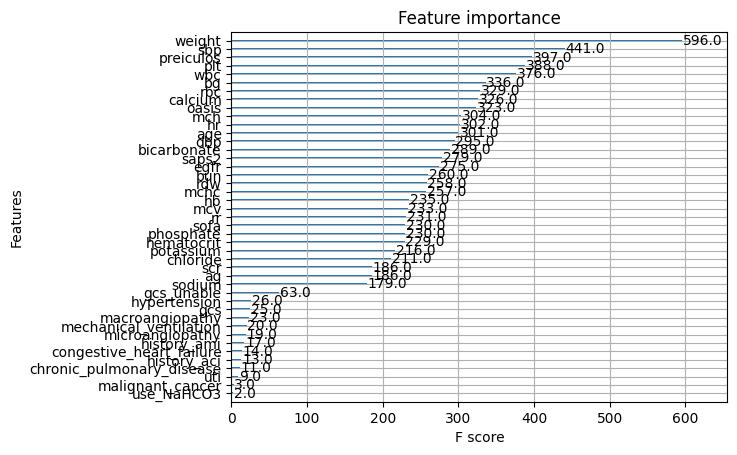

In [16]:
xgb.plot_importance(model)

ImportError: You must install graphviz to plot tree

<Figure size 3000x3000 with 0 Axes>

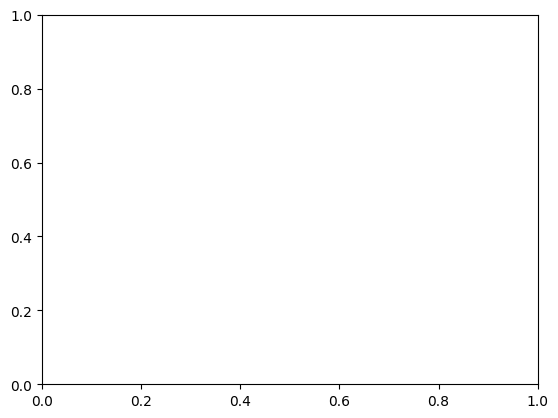

In [17]:
from matplotlib import pyplot as plt


plt.figure(figsize=(30, 30))
xgb.plot_tree(model, num_trees=3)

### Fill missing with knn

In [18]:
from sklearn.metrics import roc_auc_score
from utils.prepare_data import normalizeAndFillData


accuracy_score_list_val_knn = []
precision_score_list_val_knn = []
recall_score_list_val_knn = []
auc_score_list_val_knn = []
metric_dic_list_val_knn = []
for trainPatients, valPatients, testPatients in trainValTest():
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfVal = valPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfVal = dfVal.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, dfVal = normalizeAndFillData(dfTrain, dfTest, dfVal)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_val = dfVal.drop(columns=[labelColumn])  # type: ignore
    y_val = dfVal[labelColumn]  # type: ignore

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    model = createModel()
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

    accuracy_score_list_val_knn.append(accuracy_score(y_test, y_pred))
    precision_score_list_val_knn.append(precision_score(y_test, y_pred))
    recall_score_list_val_knn.append(recall_score(y_test, y_pred))
    auc_score_list_val_knn.append(roc_auc_score(y_test, y_pred_proba))

[0]	validation_0-logloss:0.66670


[1]	validation_0-logloss:0.66362


[2]	validation_0-logloss:0.66120


[3]	validation_0-logloss:0.65869


[4]	validation_0-logloss:0.65594


[5]	validation_0-logloss:0.65344


[6]	validation_0-logloss:0.65065


[7]	validation_0-logloss:0.64816


[8]	validation_0-logloss:0.64572


[9]	validation_0-logloss:0.64340


[10]	validation_0-logloss:0.64116


[11]	validation_0-logloss:0.63872


[12]	validation_0-logloss:0.63693


[13]	validation_0-logloss:0.63495


[14]	validation_0-logloss:0.63261


[15]	validation_0-logloss:0.63040


[16]	validation_0-logloss:0.62806


[17]	validation_0-logloss:0.62645


[18]	validation_0-logloss:0.62500


[19]	validation_0-logloss:0.62348


[20]	validation_0-logloss:0.62156


[21]	validation_0-logloss:0.61987


[22]	validation_0-logloss:0.61846


[23]	validation_0-logloss:0.61715


[24]	validation_0-logloss:0.61541


[25]	validation_0-logloss:0.61335


[26]	validation_0-logloss:0.61168


[27]	validation_0-logloss:0.60964


[28]	validation_0-logloss:0.60810


[29]	validation_0-logloss:0.60633


[30]	validation_0-logloss:0.60514


[31]	validation_0-logloss:0.60386


[32]	validation_0-logloss:0.60315


[33]	validation_0-logloss:0.60185


[34]	validation_0-logloss:0.60016


[35]	validation_0-logloss:0.59875


[36]	validation_0-logloss:0.59714


[37]	validation_0-logloss:0.59582


[38]	validation_0-logloss:0.59462


[39]	validation_0-logloss:0.59341


[40]	validation_0-logloss:0.59226


[41]	validation_0-logloss:0.59174


[42]	validation_0-logloss:0.59040


[43]	validation_0-logloss:0.58907


[44]	validation_0-logloss:0.58744


[45]	validation_0-logloss:0.58607


[46]	validation_0-logloss:0.58521


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:40:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[47]	validation_0-logloss:0.58402


[48]	validation_0-logloss:0.58308


[49]	validation_0-logloss:0.58232


[50]	validation_0-logloss:0.58094


[51]	validation_0-logloss:0.57984


[52]	validation_0-logloss:0.57862

[53]	validation_0-logloss:0.57764


[54]	validation_0-logloss:0.57639


[55]	validation_0-logloss:0.57493


[56]	validation_0-logloss:0.57426


[57]	validation_0-logloss:0.57360

[58]	validation_0-logloss:0.57231


[59]	validation_0-logloss:0.57111


[60]	validation_0-logloss:0.57037


[61]	validation_0-logloss:0.56937


[62]	validation_0-logloss:0.56810


[63]	validation_0-logloss:0.56718


[64]	validation_0-logloss:0.56601


[65]	validation_0-logloss:0.56508


[66]	validation_0-logloss:0.56407


[67]	validation_0-logloss:0.56332


[68]	validation_0-logloss:0.56259


[69]	validation_0-logloss:0.56177


[70]	validation_0-logloss:0.56049


[71]	validation_0-logloss:0.55970


[72]	validation_0-logloss:0.55858


[73]	validation_0-logloss:0.55766


[74]	validation_0-logloss:0.55704


[75]	validation_0-logloss:0.55616


[76]	validation_0-logloss:0.55540


[77]	validation_0-logloss:0.55402


[78]	validation_0-logloss:0.55295


[79]	validation_0-logloss:0.55281


[80]	validation_0-logloss:0.55220


[81]	validation_0-logloss:0.55123


[82]	validation_0-logloss:0.55009


[83]	validation_0-logloss:0.54955


[84]	validation_0-logloss:0.54886


[85]	validation_0-logloss:0.54829


[86]	validation_0-logloss:0.54809


[87]	validation_0-logloss:0.54761


[88]	validation_0-logloss:0.54680

[89]	validation_0-logloss:0.54596


[90]	validation_0-logloss:0.54555


[91]	validation_0-logloss:0.54510


[92]	validation_0-logloss:0.54463


[93]	validation_0-logloss:0.54379


[94]	validation_0-logloss:0.54293


[95]	validation_0-logloss:0.54252


[96]	validation_0-logloss:0.54251


[97]	validation_0-logloss:0.54212


[98]	validation_0-logloss:0.54154

[99]	validation_0-logloss:0.54086


[100]	validation_0-logloss:0.54040


[101]	validation_0-logloss:0.54017


[102]	validation_0-logloss:0.53916


[103]	validation_0-logloss:0.53874


[104]	validation_0-logloss:0.53820


[105]	validation_0-logloss:0.53727


[106]	validation_0-logloss:0.53639


[107]	validation_0-logloss:0.53562

[108]	validation_0-logloss:0.53499


[109]	validation_0-logloss:0.53450


[110]	validation_0-logloss:0.53390


[111]	validation_0-logloss:0.53341


[112]	validation_0-logloss:0.53306


[113]	validation_0-logloss:0.53292


[114]	validation_0-logloss:0.53258


[115]	validation_0-logloss:0.53210


[116]	validation_0-logloss:0.53123


[117]	validation_0-logloss:0.53128


[118]	validation_0-logloss:0.53063


[119]	validation_0-logloss:0.53009


[120]	validation_0-logloss:0.52963


[121]	validation_0-logloss:0.52937


[122]	validation_0-logloss:0.52855


[123]	validation_0-logloss:0.52783


[124]	validation_0-logloss:0.52704

[125]	validation_0-logloss:0.52634


[126]	validation_0-logloss:0.52569


[127]	validation_0-logloss:0.52551


[128]	validation_0-logloss:0.52511

[129]	validation_0-logloss:0.52479


[130]	validation_0-logloss:0.52446


[131]	validation_0-logloss:0.52428


[132]	validation_0-logloss:0.52372


[133]	validation_0-logloss:0.52313


[134]	validation_0-logloss:0.52312


[135]	validation_0-logloss:0.52284


[136]	validation_0-logloss:0.52259

[137]	validation_0-logloss:0.52210


[138]	validation_0-logloss:0.52159


[139]	validation_0-logloss:0.52132


[140]	validation_0-logloss:0.52108


[141]	validation_0-logloss:0.52097


[142]	validation_0-logloss:0.52054


[143]	validation_0-logloss:0.51989


[144]	validation_0-logloss:0.51967


[145]	validation_0-logloss:0.51916


[146]	validation_0-logloss:0.51877


[147]	validation_0-logloss:0.51828

[148]	validation_0-logloss:0.51757


[149]	validation_0-logloss:0.51701


[150]	validation_0-logloss:0.51671


[151]	validation_0-logloss:0.51651

[152]	validation_0-logloss:0.51610


[153]	validation_0-logloss:0.51594

[154]	validation_0-logloss:0.51573


[155]	validation_0-logloss:0.51544

[156]	validation_0-logloss:0.51529


[157]	validation_0-logloss:0.51498


[158]	validation_0-logloss:0.51447


[159]	validation_0-logloss:0.51425


[160]	validation_0-logloss:0.51408

[161]	validation_0-logloss:0.51357


[162]	validation_0-logloss:0.51295


[163]	validation_0-logloss:0.51241


[164]	validation_0-logloss:0.51178

[165]	validation_0-logloss:0.51131

[166]	validation_0-logloss:0.51110


[167]	validation_0-logloss:0.51130


[168]	validation_0-logloss:0.51088

[169]	validation_0-logloss:0.51038


[170]	validation_0-logloss:0.51022


[171]	validation_0-logloss:0.50966


[172]	validation_0-logloss:0.50953


[173]	validation_0-logloss:0.50947


[174]	validation_0-logloss:0.50954


[175]	validation_0-logloss:0.50905


[176]	validation_0-logloss:0.50849


[177]	validation_0-logloss:0.50783


[178]	validation_0-logloss:0.50761


[179]	validation_0-logloss:0.50706


[180]	validation_0-logloss:0.50694


[181]	validation_0-logloss:0.50686


[182]	validation_0-logloss:0.50653


[183]	validation_0-logloss:0.50643


[184]	validation_0-logloss:0.50645


[185]	validation_0-logloss:0.50636


[186]	validation_0-logloss:0.50643


[187]	validation_0-logloss:0.50607


[188]	validation_0-logloss:0.50598


[189]	validation_0-logloss:0.50560


[190]	validation_0-logloss:0.50561


[191]	validation_0-logloss:0.50548


[192]	validation_0-logloss:0.50567


[193]	validation_0-logloss:0.50546


[194]	validation_0-logloss:0.50537


[195]	validation_0-logloss:0.50466


[196]	validation_0-logloss:0.50456


[197]	validation_0-logloss:0.50458


[198]	validation_0-logloss:0.50459


[199]	validation_0-logloss:0.50466


[200]	validation_0-logloss:0.50457


[201]	validation_0-logloss:0.50408


[202]	validation_0-logloss:0.50342


[203]	validation_0-logloss:0.50308


[204]	validation_0-logloss:0.50288


[205]	validation_0-logloss:0.50250


[206]	validation_0-logloss:0.50230


[207]	validation_0-logloss:0.50238


[208]	validation_0-logloss:0.50212


[209]	validation_0-logloss:0.50199


[210]	validation_0-logloss:0.50185

[211]	validation_0-logloss:0.50211


[212]	validation_0-logloss:0.50165


[213]	validation_0-logloss:0.50141


[214]	validation_0-logloss:0.50166


[215]	validation_0-logloss:0.50181


[216]	validation_0-logloss:0.50166


[217]	validation_0-logloss:0.50148


[218]	validation_0-logloss:0.50144


[219]	validation_0-logloss:0.50134


[220]	validation_0-logloss:0.50133


[221]	validation_0-logloss:0.50116


[222]	validation_0-logloss:0.50072


[223]	validation_0-logloss:0.50075


[224]	validation_0-logloss:0.50080


[225]	validation_0-logloss:0.50079


[226]	validation_0-logloss:0.50074


[227]	validation_0-logloss:0.50110


[228]	validation_0-logloss:0.50059


[229]	validation_0-logloss:0.50007


[230]	validation_0-logloss:0.49987


[231]	validation_0-logloss:0.49997


[232]	validation_0-logloss:0.49975


[233]	validation_0-logloss:0.49933


[234]	validation_0-logloss:0.49915


[235]	validation_0-logloss:0.49884


[236]	validation_0-logloss:0.49865


[237]	validation_0-logloss:0.49837


[238]	validation_0-logloss:0.49823


[239]	validation_0-logloss:0.49818


[240]	validation_0-logloss:0.49798


[241]	validation_0-logloss:0.49759

[242]	validation_0-logloss:0.49786


[243]	validation_0-logloss:0.49784


[244]	validation_0-logloss:0.49758


[245]	validation_0-logloss:0.49748


[246]	validation_0-logloss:0.49721


[247]	validation_0-logloss:0.49696


[248]	validation_0-logloss:0.49679


[249]	validation_0-logloss:0.49666


[250]	validation_0-logloss:0.49674


[251]	validation_0-logloss:0.49689


[252]	validation_0-logloss:0.49679


[253]	validation_0-logloss:0.49659

[254]	validation_0-logloss:0.49633

[255]	validation_0-logloss:0.49654


[256]	validation_0-logloss:0.49648


[257]	validation_0-logloss:0.49651


[258]	validation_0-logloss:0.49654

[259]	validation_0-logloss:0.49640


[260]	validation_0-logloss:0.49640


[261]	validation_0-logloss:0.49650


[262]	validation_0-logloss:0.49643


[263]	validation_0-logloss:0.49640

[264]	validation_0-logloss:0.49636


[0]	validation_0-logloss:0.66747


[1]	validation_0-logloss:0.66530


[2]	validation_0-logloss:0.66316


[3]	validation_0-logloss:0.66087


[4]	validation_0-logloss:0.65809


[5]	validation_0-logloss:0.65578


[6]	validation_0-logloss:0.65295


[7]	validation_0-logloss:0.65029


[8]	validation_0-logloss:0.64765


[9]	validation_0-logloss:0.64517


[10]	validation_0-logloss:0.64307


[11]	validation_0-logloss:0.64117


[12]	validation_0-logloss:0.63980


[13]	validation_0-logloss:0.63782


[14]	validation_0-logloss:0.63581


[15]	validation_0-logloss:0.63359


[16]	validation_0-logloss:0.63174


[17]	validation_0-logloss:0.63033


[18]	validation_0-logloss:0.62877


[19]	validation_0-logloss:0.62689


[20]	validation_0-logloss:0.62537


[21]	validation_0-logloss:0.62324


[22]	validation_0-logloss:0.62198


[23]	validation_0-logloss:0.62003


[24]	validation_0-logloss:0.61841


[25]	validation_0-logloss:0.61685


[26]	validation_0-logloss:0.61549


[27]	validation_0-logloss:0.61407


[28]	validation_0-logloss:0.61261


[29]	validation_0-logloss:0.61158


[30]	validation_0-logloss:0.61021


[31]	validation_0-logloss:0.60864


[32]	validation_0-logloss:0.60736


[33]	validation_0-logloss:0.60584


[34]	validation_0-logloss:0.60451


[35]	validation_0-logloss:0.60269


[36]	validation_0-logloss:0.60115


[37]	validation_0-logloss:0.59977


[38]	validation_0-logloss:0.59835


[39]	validation_0-logloss:0.59708


[40]	validation_0-logloss:0.59624


[41]	validation_0-logloss:0.59528


[42]	validation_0-logloss:0.59398


[43]	validation_0-logloss:0.59285


[44]	validation_0-logloss:0.59124


[45]	validation_0-logloss:0.58993


[46]	validation_0-logloss:0.58851


[47]	validation_0-logloss:0.58742


[48]	validation_0-logloss:0.58589


[49]	validation_0-logloss:0.58507


[50]	validation_0-logloss:0.58360


[51]	validation_0-logloss:0.58222


[52]	validation_0-logloss:0.58090


[53]	validation_0-logloss:0.58017


[54]	validation_0-logloss:0.57892


[55]	validation_0-logloss:0.57760


[56]	validation_0-logloss:0.57613


[57]	validation_0-logloss:0.57517


[58]	validation_0-logloss:0.57417


[59]	validation_0-logloss:0.57320


[60]	validation_0-logloss:0.57233


[61]	validation_0-logloss:0.57145


[62]	validation_0-logloss:0.57072


[63]	validation_0-logloss:0.56967


[64]	validation_0-logloss:0.56881


[65]	validation_0-logloss:0.56786


[66]	validation_0-logloss:0.56635


[67]	validation_0-logloss:0.56573


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:41:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[68]	validation_0-logloss:0.56462


[69]	validation_0-logloss:0.56402

[70]	validation_0-logloss:0.56290


[71]	validation_0-logloss:0.56207


[72]	validation_0-logloss:0.56120


[73]	validation_0-logloss:0.56044


[74]	validation_0-logloss:0.55930


[75]	validation_0-logloss:0.55907


[76]	validation_0-logloss:0.55852


[77]	validation_0-logloss:0.55753


[78]	validation_0-logloss:0.55712

[79]	validation_0-logloss:0.55627


[80]	validation_0-logloss:0.55540


[81]	validation_0-logloss:0.55487

[82]	validation_0-logloss:0.55426


[83]	validation_0-logloss:0.55330


[84]	validation_0-logloss:0.55261


[85]	validation_0-logloss:0.55213


[86]	validation_0-logloss:0.55114


[87]	validation_0-logloss:0.54993


[88]	validation_0-logloss:0.54915


[89]	validation_0-logloss:0.54850


[90]	validation_0-logloss:0.54781


[91]	validation_0-logloss:0.54706


[92]	validation_0-logloss:0.54654


[93]	validation_0-logloss:0.54565


[94]	validation_0-logloss:0.54481


[95]	validation_0-logloss:0.54431


[96]	validation_0-logloss:0.54364


[97]	validation_0-logloss:0.54310


[98]	validation_0-logloss:0.54250


[99]	validation_0-logloss:0.54203


[100]	validation_0-logloss:0.54159


[101]	validation_0-logloss:0.54072


[102]	validation_0-logloss:0.54023


[103]	validation_0-logloss:0.53950


[104]	validation_0-logloss:0.53916


[105]	validation_0-logloss:0.53835


[106]	validation_0-logloss:0.53817


[107]	validation_0-logloss:0.53784


[108]	validation_0-logloss:0.53722


[109]	validation_0-logloss:0.53662


[110]	validation_0-logloss:0.53653


[111]	validation_0-logloss:0.53621


[112]	validation_0-logloss:0.53572


[113]	validation_0-logloss:0.53531


[114]	validation_0-logloss:0.53472


[115]	validation_0-logloss:0.53400


[116]	validation_0-logloss:0.53354


[117]	validation_0-logloss:0.53318


[118]	validation_0-logloss:0.53265


[119]	validation_0-logloss:0.53229


[120]	validation_0-logloss:0.53182


[121]	validation_0-logloss:0.53113

[122]	validation_0-logloss:0.53063


[123]	validation_0-logloss:0.53040


[124]	validation_0-logloss:0.53008


[125]	validation_0-logloss:0.53008


[126]	validation_0-logloss:0.52948


[127]	validation_0-logloss:0.52868


[128]	validation_0-logloss:0.52835


[129]	validation_0-logloss:0.52750


[130]	validation_0-logloss:0.52659


[131]	validation_0-logloss:0.52595


[132]	validation_0-logloss:0.52578


[133]	validation_0-logloss:0.52518


[134]	validation_0-logloss:0.52468


[135]	validation_0-logloss:0.52429


[136]	validation_0-logloss:0.52389


[137]	validation_0-logloss:0.52365


[138]	validation_0-logloss:0.52360


[139]	validation_0-logloss:0.52315


[140]	validation_0-logloss:0.52294


[141]	validation_0-logloss:0.52251


[142]	validation_0-logloss:0.52237


[143]	validation_0-logloss:0.52186


[144]	validation_0-logloss:0.52171


[145]	validation_0-logloss:0.52153


[146]	validation_0-logloss:0.52099


[147]	validation_0-logloss:0.52077


[148]	validation_0-logloss:0.52031


[149]	validation_0-logloss:0.51980


[150]	validation_0-logloss:0.51967


[151]	validation_0-logloss:0.51938


[152]	validation_0-logloss:0.51935


[153]	validation_0-logloss:0.51917


[154]	validation_0-logloss:0.51882


[155]	validation_0-logloss:0.51862


[156]	validation_0-logloss:0.51831

[157]	validation_0-logloss:0.51801


[158]	validation_0-logloss:0.51776


[159]	validation_0-logloss:0.51771


[160]	validation_0-logloss:0.51745


[161]	validation_0-logloss:0.51720


[162]	validation_0-logloss:0.51669


[163]	validation_0-logloss:0.51667


[164]	validation_0-logloss:0.51660


[165]	validation_0-logloss:0.51625


[166]	validation_0-logloss:0.51569


[167]	validation_0-logloss:0.51560


[168]	validation_0-logloss:0.51545

[169]	validation_0-logloss:0.51517


[170]	validation_0-logloss:0.51458


[171]	validation_0-logloss:0.51439


[172]	validation_0-logloss:0.51427


[173]	validation_0-logloss:0.51374


[174]	validation_0-logloss:0.51385


[175]	validation_0-logloss:0.51356


[176]	validation_0-logloss:0.51346


[177]	validation_0-logloss:0.51337


[178]	validation_0-logloss:0.51314


[179]	validation_0-logloss:0.51270


[180]	validation_0-logloss:0.51265


[181]	validation_0-logloss:0.51263


[182]	validation_0-logloss:0.51290

[183]	validation_0-logloss:0.51263


[184]	validation_0-logloss:0.51239


[185]	validation_0-logloss:0.51202


[186]	validation_0-logloss:0.51176


[187]	validation_0-logloss:0.51156


[188]	validation_0-logloss:0.51144


[189]	validation_0-logloss:0.51117


[190]	validation_0-logloss:0.51107


[191]	validation_0-logloss:0.51092

[192]	validation_0-logloss:0.51109


[193]	validation_0-logloss:0.51071


[194]	validation_0-logloss:0.51053

[195]	validation_0-logloss:0.51037


[196]	validation_0-logloss:0.51053


[197]	validation_0-logloss:0.51056


[198]	validation_0-logloss:0.51045


[199]	validation_0-logloss:0.51011


[200]	validation_0-logloss:0.51001


[201]	validation_0-logloss:0.50990


[202]	validation_0-logloss:0.50974


[203]	validation_0-logloss:0.50973


[204]	validation_0-logloss:0.50960


[205]	validation_0-logloss:0.50938


[206]	validation_0-logloss:0.50899


[207]	validation_0-logloss:0.50854


[208]	validation_0-logloss:0.50826


[209]	validation_0-logloss:0.50790


[210]	validation_0-logloss:0.50815


[211]	validation_0-logloss:0.50806


[212]	validation_0-logloss:0.50773


[213]	validation_0-logloss:0.50754


[214]	validation_0-logloss:0.50745


[215]	validation_0-logloss:0.50743


[216]	validation_0-logloss:0.50744


[217]	validation_0-logloss:0.50730


[218]	validation_0-logloss:0.50712


[219]	validation_0-logloss:0.50715


[220]	validation_0-logloss:0.50705


[221]	validation_0-logloss:0.50677


[222]	validation_0-logloss:0.50658


[223]	validation_0-logloss:0.50648


[224]	validation_0-logloss:0.50623


[225]	validation_0-logloss:0.50610


[226]	validation_0-logloss:0.50595


[227]	validation_0-logloss:0.50585


[228]	validation_0-logloss:0.50590


[229]	validation_0-logloss:0.50579


[230]	validation_0-logloss:0.50563


[231]	validation_0-logloss:0.50575


[232]	validation_0-logloss:0.50572


[233]	validation_0-logloss:0.50576


[234]	validation_0-logloss:0.50567


[235]	validation_0-logloss:0.50526


[236]	validation_0-logloss:0.50489


[237]	validation_0-logloss:0.50478

[238]	validation_0-logloss:0.50466


[239]	validation_0-logloss:0.50442


[240]	validation_0-logloss:0.50441


[241]	validation_0-logloss:0.50468


[242]	validation_0-logloss:0.50464


[243]	validation_0-logloss:0.50441


[244]	validation_0-logloss:0.50409


[245]	validation_0-logloss:0.50380


[246]	validation_0-logloss:0.50374


[247]	validation_0-logloss:0.50361


[248]	validation_0-logloss:0.50359


[249]	validation_0-logloss:0.50341


[250]	validation_0-logloss:0.50325


[251]	validation_0-logloss:0.50322


[252]	validation_0-logloss:0.50319


[253]	validation_0-logloss:0.50329


[254]	validation_0-logloss:0.50337


[255]	validation_0-logloss:0.50328


[256]	validation_0-logloss:0.50266


[257]	validation_0-logloss:0.50245


[258]	validation_0-logloss:0.50232


[259]	validation_0-logloss:0.50241


[260]	validation_0-logloss:0.50250


[261]	validation_0-logloss:0.50227


[262]	validation_0-logloss:0.50219


[263]	validation_0-logloss:0.50225


[264]	validation_0-logloss:0.50204


[265]	validation_0-logloss:0.50169


[266]	validation_0-logloss:0.50168

[267]	validation_0-logloss:0.50158

[268]	validation_0-logloss:0.50162


[269]	validation_0-logloss:0.50143


[270]	validation_0-logloss:0.50162


[271]	validation_0-logloss:0.50160


[272]	validation_0-logloss:0.50166


[273]	validation_0-logloss:0.50164


[274]	validation_0-logloss:0.50154


[275]	validation_0-logloss:0.50170


[276]	validation_0-logloss:0.50162


[277]	validation_0-logloss:0.50141


[278]	validation_0-logloss:0.50155


[279]	validation_0-logloss:0.50124


[280]	validation_0-logloss:0.50122


[281]	validation_0-logloss:0.50139

[282]	validation_0-logloss:0.50125


[283]	validation_0-logloss:0.50114

[284]	validation_0-logloss:0.50094


[285]	validation_0-logloss:0.50071


[286]	validation_0-logloss:0.50068


[287]	validation_0-logloss:0.50066


[288]	validation_0-logloss:0.50041


[289]	validation_0-logloss:0.50019


[290]	validation_0-logloss:0.50037


[291]	validation_0-logloss:0.50027


[292]	validation_0-logloss:0.49991


[293]	validation_0-logloss:0.49984

[294]	validation_0-logloss:0.49969


[295]	validation_0-logloss:0.49964


[296]	validation_0-logloss:0.49977


[297]	validation_0-logloss:0.49970


[298]	validation_0-logloss:0.49985


[299]	validation_0-logloss:0.49958


[300]	validation_0-logloss:0.49981


[301]	validation_0-logloss:0.49964


[302]	validation_0-logloss:0.49958


[303]	validation_0-logloss:0.49962


[304]	validation_0-logloss:0.49938


[305]	validation_0-logloss:0.49941


[306]	validation_0-logloss:0.49939


[307]	validation_0-logloss:0.49926


[308]	validation_0-logloss:0.49920


[309]	validation_0-logloss:0.49943


[310]	validation_0-logloss:0.49960


[311]	validation_0-logloss:0.49944


[312]	validation_0-logloss:0.49942


[313]	validation_0-logloss:0.49929


[314]	validation_0-logloss:0.49916


[315]	validation_0-logloss:0.49946


[316]	validation_0-logloss:0.49961


[317]	validation_0-logloss:0.49970


[318]	validation_0-logloss:0.49965


[319]	validation_0-logloss:0.49975


[320]	validation_0-logloss:0.49992


[321]	validation_0-logloss:0.49986


[322]	validation_0-logloss:0.49973


[323]	validation_0-logloss:0.49971

[0]	validation_0-logloss:0.66804


[1]	validation_0-logloss:0.66550


[2]	validation_0-logloss:0.66363


[3]	validation_0-logloss:0.66162


[4]	validation_0-logloss:0.65948


[5]	validation_0-logloss:0.65753


[6]	validation_0-logloss:0.65575


[7]	validation_0-logloss:0.65348


[8]	validation_0-logloss:0.65168


[9]	validation_0-logloss:0.64967


[10]	validation_0-logloss:0.64815


[11]	validation_0-logloss:0.64613


[12]	validation_0-logloss:0.64462


[13]	validation_0-logloss:0.64278


[14]	validation_0-logloss:0.64043


[15]	validation_0-logloss:0.63874


[16]	validation_0-logloss:0.63714


[17]	validation_0-logloss:0.63539


[18]	validation_0-logloss:0.63436


[19]	validation_0-logloss:0.63277


[20]	validation_0-logloss:0.63088


[21]	validation_0-logloss:0.62944


[22]	validation_0-logloss:0.62736


[23]	validation_0-logloss:0.62537


[24]	validation_0-logloss:0.62374


[25]	validation_0-logloss:0.62201


[26]	validation_0-logloss:0.62043


[27]	validation_0-logloss:0.61899


[28]	validation_0-logloss:0.61771


[29]	validation_0-logloss:0.61660


[30]	validation_0-logloss:0.61578


[31]	validation_0-logloss:0.61478


[32]	validation_0-logloss:0.61350


[33]	validation_0-logloss:0.61215


[34]	validation_0-logloss:0.61127


[35]	validation_0-logloss:0.60989


[36]	validation_0-logloss:0.60898


[37]	validation_0-logloss:0.60801


[38]	validation_0-logloss:0.60706


[39]	validation_0-logloss:0.60534


[40]	validation_0-logloss:0.60415


[41]	validation_0-logloss:0.60310


[42]	validation_0-logloss:0.60185


[43]	validation_0-logloss:0.60012


[44]	validation_0-logloss:0.59864


[45]	validation_0-logloss:0.59768


[46]	validation_0-logloss:0.59689


[47]	validation_0-logloss:0.59601


[48]	validation_0-logloss:0.59541


[49]	validation_0-logloss:0.59450


[50]	validation_0-logloss:0.59323


[51]	validation_0-logloss:0.59258


[52]	validation_0-logloss:0.59133


[53]	validation_0-logloss:0.59037


[54]	validation_0-logloss:0.58965


[55]	validation_0-logloss:0.58869


[56]	validation_0-logloss:0.58782


[57]	validation_0-logloss:0.58696


[58]	validation_0-logloss:0.58628


[59]	validation_0-logloss:0.58515


[60]	validation_0-logloss:0.58426


[61]	validation_0-logloss:0.58337


[62]	validation_0-logloss:0.58272


[63]	validation_0-logloss:0.58136


[64]	validation_0-logloss:0.58071


[65]	validation_0-logloss:0.57986


[66]	validation_0-logloss:0.57924


[67]	validation_0-logloss:0.57823


[68]	validation_0-logloss:0.57753


[69]	validation_0-logloss:0.57673


[70]	validation_0-logloss:0.57585


[71]	validation_0-logloss:0.57601


[72]	validation_0-logloss:0.57518


[73]	validation_0-logloss:0.57418


[74]	validation_0-logloss:0.57297


[75]	validation_0-logloss:0.57247


[76]	validation_0-logloss:0.57181


[77]	validation_0-logloss:0.57089


[78]	validation_0-logloss:0.56993


[79]	validation_0-logloss:0.56957


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:41:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[80]	validation_0-logloss:0.56889


[81]	validation_0-logloss:0.56832


[82]	validation_0-logloss:0.56836

[83]	validation_0-logloss:0.56775

[84]	validation_0-logloss:0.56682


[85]	validation_0-logloss:0.56649


[86]	validation_0-logloss:0.56616

[87]	validation_0-logloss:0.56570


[88]	validation_0-logloss:0.56483


[89]	validation_0-logloss:0.56446

[90]	validation_0-logloss:0.56375


[91]	validation_0-logloss:0.56335


[92]	validation_0-logloss:0.56286


[93]	validation_0-logloss:0.56220

[94]	validation_0-logloss:0.56167


[95]	validation_0-logloss:0.56151


[96]	validation_0-logloss:0.56126


[97]	validation_0-logloss:0.56103


[98]	validation_0-logloss:0.56051


[99]	validation_0-logloss:0.56014


[100]	validation_0-logloss:0.56021

[101]	validation_0-logloss:0.55982


[102]	validation_0-logloss:0.55963


[103]	validation_0-logloss:0.55881

[104]	validation_0-logloss:0.55808


[105]	validation_0-logloss:0.55783


[106]	validation_0-logloss:0.55753


[107]	validation_0-logloss:0.55710


[108]	validation_0-logloss:0.55646


[109]	validation_0-logloss:0.55604


[110]	validation_0-logloss:0.55568


[111]	validation_0-logloss:0.55550


[112]	validation_0-logloss:0.55506


[113]	validation_0-logloss:0.55435


[114]	validation_0-logloss:0.55414


[115]	validation_0-logloss:0.55379


[116]	validation_0-logloss:0.55326


[117]	validation_0-logloss:0.55299


[118]	validation_0-logloss:0.55243


[119]	validation_0-logloss:0.55213


[120]	validation_0-logloss:0.55192


[121]	validation_0-logloss:0.55149


[122]	validation_0-logloss:0.55117


[123]	validation_0-logloss:0.55103


[124]	validation_0-logloss:0.55077


[125]	validation_0-logloss:0.55047


[126]	validation_0-logloss:0.55039


[127]	validation_0-logloss:0.55013


[128]	validation_0-logloss:0.54955


[129]	validation_0-logloss:0.54949


[130]	validation_0-logloss:0.54953


[131]	validation_0-logloss:0.54960


[132]	validation_0-logloss:0.54961


[133]	validation_0-logloss:0.54940

[134]	validation_0-logloss:0.54906


[135]	validation_0-logloss:0.54862


[136]	validation_0-logloss:0.54834


[137]	validation_0-logloss:0.54811


[138]	validation_0-logloss:0.54802


[139]	validation_0-logloss:0.54830


[140]	validation_0-logloss:0.54759


[141]	validation_0-logloss:0.54743


[142]	validation_0-logloss:0.54751


[143]	validation_0-logloss:0.54702


[144]	validation_0-logloss:0.54696


[145]	validation_0-logloss:0.54707


[146]	validation_0-logloss:0.54645


[147]	validation_0-logloss:0.54592


[148]	validation_0-logloss:0.54558


[149]	validation_0-logloss:0.54513


[150]	validation_0-logloss:0.54456


[151]	validation_0-logloss:0.54451


[152]	validation_0-logloss:0.54465


[153]	validation_0-logloss:0.54447

[154]	validation_0-logloss:0.54438


[155]	validation_0-logloss:0.54421


[156]	validation_0-logloss:0.54408


[157]	validation_0-logloss:0.54402


[158]	validation_0-logloss:0.54358


[159]	validation_0-logloss:0.54374


[160]	validation_0-logloss:0.54359

[161]	validation_0-logloss:0.54362


[162]	validation_0-logloss:0.54345


[163]	validation_0-logloss:0.54321


[164]	validation_0-logloss:0.54311


[165]	validation_0-logloss:0.54265


[166]	validation_0-logloss:0.54270


[167]	validation_0-logloss:0.54249


[168]	validation_0-logloss:0.54228


[169]	validation_0-logloss:0.54251


[170]	validation_0-logloss:0.54230


[171]	validation_0-logloss:0.54226


[172]	validation_0-logloss:0.54233


[173]	validation_0-logloss:0.54237


[174]	validation_0-logloss:0.54241


[175]	validation_0-logloss:0.54222


[176]	validation_0-logloss:0.54272


[177]	validation_0-logloss:0.54269


[178]	validation_0-logloss:0.54262


[179]	validation_0-logloss:0.54268


[180]	validation_0-logloss:0.54240


[181]	validation_0-logloss:0.54225


[182]	validation_0-logloss:0.54224


[183]	validation_0-logloss:0.54204


[184]	validation_0-logloss:0.54168


[185]	validation_0-logloss:0.54151


[186]	validation_0-logloss:0.54147


[187]	validation_0-logloss:0.54152


[188]	validation_0-logloss:0.54117


[189]	validation_0-logloss:0.54133


[190]	validation_0-logloss:0.54096


[191]	validation_0-logloss:0.54046


[192]	validation_0-logloss:0.54008


[193]	validation_0-logloss:0.53979


[194]	validation_0-logloss:0.53937


[195]	validation_0-logloss:0.53950


[196]	validation_0-logloss:0.53924


[197]	validation_0-logloss:0.53927


[198]	validation_0-logloss:0.53905


[199]	validation_0-logloss:0.53938


[200]	validation_0-logloss:0.53896


[201]	validation_0-logloss:0.53882


[202]	validation_0-logloss:0.53847


[203]	validation_0-logloss:0.53848


[204]	validation_0-logloss:0.53871


[205]	validation_0-logloss:0.53879


[206]	validation_0-logloss:0.53895


[207]	validation_0-logloss:0.53862


[208]	validation_0-logloss:0.53846


[209]	validation_0-logloss:0.53853


[210]	validation_0-logloss:0.53870


[211]	validation_0-logloss:0.53842


[212]	validation_0-logloss:0.53830


[213]	validation_0-logloss:0.53806


[214]	validation_0-logloss:0.53812

[215]	validation_0-logloss:0.53804


[216]	validation_0-logloss:0.53829


[217]	validation_0-logloss:0.53826

[218]	validation_0-logloss:0.53837


[219]	validation_0-logloss:0.53797


[220]	validation_0-logloss:0.53771


[221]	validation_0-logloss:0.53763


[222]	validation_0-logloss:0.53775


[223]	validation_0-logloss:0.53774


[224]	validation_0-logloss:0.53728


[225]	validation_0-logloss:0.53707


[226]	validation_0-logloss:0.53711


[227]	validation_0-logloss:0.53721


[228]	validation_0-logloss:0.53692


[229]	validation_0-logloss:0.53713


[230]	validation_0-logloss:0.53728


[231]	validation_0-logloss:0.53687


[232]	validation_0-logloss:0.53716


[233]	validation_0-logloss:0.53725


[234]	validation_0-logloss:0.53712


[235]	validation_0-logloss:0.53731


[236]	validation_0-logloss:0.53748


[237]	validation_0-logloss:0.53736


[238]	validation_0-logloss:0.53769


[239]	validation_0-logloss:0.53749


[240]	validation_0-logloss:0.53732


[0]	validation_0-logloss:0.66762


[1]	validation_0-logloss:0.66553


[2]	validation_0-logloss:0.66309


[3]	validation_0-logloss:0.66167


[4]	validation_0-logloss:0.65932


[5]	validation_0-logloss:0.65715


[6]	validation_0-logloss:0.65525


[7]	validation_0-logloss:0.65326


[8]	validation_0-logloss:0.65138


[9]	validation_0-logloss:0.64986


[10]	validation_0-logloss:0.64853


[11]	validation_0-logloss:0.64668


[12]	validation_0-logloss:0.64539


[13]	validation_0-logloss:0.64370


[14]	validation_0-logloss:0.64211


[15]	validation_0-logloss:0.64036


[16]	validation_0-logloss:0.63904


[17]	validation_0-logloss:0.63716


[18]	validation_0-logloss:0.63574


[19]	validation_0-logloss:0.63443


[20]	validation_0-logloss:0.63283


[21]	validation_0-logloss:0.63093


[22]	validation_0-logloss:0.62904


[23]	validation_0-logloss:0.62711


[24]	validation_0-logloss:0.62539


[25]	validation_0-logloss:0.62354


[26]	validation_0-logloss:0.62191


[27]	validation_0-logloss:0.62041


[28]	validation_0-logloss:0.61895


[29]	validation_0-logloss:0.61733


[30]	validation_0-logloss:0.61646


[31]	validation_0-logloss:0.61536


[32]	validation_0-logloss:0.61393


[33]	validation_0-logloss:0.61228


[34]	validation_0-logloss:0.61073


[35]	validation_0-logloss:0.60959


[36]	validation_0-logloss:0.60762


[37]	validation_0-logloss:0.60641


[38]	validation_0-logloss:0.60521


[39]	validation_0-logloss:0.60448


[40]	validation_0-logloss:0.60335


[41]	validation_0-logloss:0.60178


[42]	validation_0-logloss:0.60075


[43]	validation_0-logloss:0.59954


[44]	validation_0-logloss:0.59824


[45]	validation_0-logloss:0.59696


[46]	validation_0-logloss:0.59586


[47]	validation_0-logloss:0.59462


[48]	validation_0-logloss:0.59316


[49]	validation_0-logloss:0.59231


[50]	validation_0-logloss:0.59139


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:41:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[51]	validation_0-logloss:0.59019


[52]	validation_0-logloss:0.58927


[53]	validation_0-logloss:0.58825


[54]	validation_0-logloss:0.58717


[55]	validation_0-logloss:0.58566


[56]	validation_0-logloss:0.58488

[57]	validation_0-logloss:0.58361


[58]	validation_0-logloss:0.58230


[59]	validation_0-logloss:0.58169


[60]	validation_0-logloss:0.58061


[61]	validation_0-logloss:0.57947


[62]	validation_0-logloss:0.57832


[63]	validation_0-logloss:0.57748


[64]	validation_0-logloss:0.57656


[65]	validation_0-logloss:0.57577


[66]	validation_0-logloss:0.57550


[67]	validation_0-logloss:0.57458

[68]	validation_0-logloss:0.57357


[69]	validation_0-logloss:0.57278


[70]	validation_0-logloss:0.57179


[71]	validation_0-logloss:0.57153


[72]	validation_0-logloss:0.57056


[73]	validation_0-logloss:0.56991


[74]	validation_0-logloss:0.56916


[75]	validation_0-logloss:0.56876


[76]	validation_0-logloss:0.56824


[77]	validation_0-logloss:0.56771


[78]	validation_0-logloss:0.56683


[79]	validation_0-logloss:0.56617


[80]	validation_0-logloss:0.56504


[81]	validation_0-logloss:0.56442


[82]	validation_0-logloss:0.56378

[83]	validation_0-logloss:0.56333


[84]	validation_0-logloss:0.56293


[85]	validation_0-logloss:0.56233


[86]	validation_0-logloss:0.56174


[87]	validation_0-logloss:0.56107

[88]	validation_0-logloss:0.56073


[89]	validation_0-logloss:0.56020


[90]	validation_0-logloss:0.56011


[91]	validation_0-logloss:0.55917


[92]	validation_0-logloss:0.55890


[93]	validation_0-logloss:0.55883


[94]	validation_0-logloss:0.55814


[95]	validation_0-logloss:0.55758


[96]	validation_0-logloss:0.55684


[97]	validation_0-logloss:0.55602


[98]	validation_0-logloss:0.55584


[99]	validation_0-logloss:0.55529


[100]	validation_0-logloss:0.55497


[101]	validation_0-logloss:0.55446


[102]	validation_0-logloss:0.55418


[103]	validation_0-logloss:0.55351

[104]	validation_0-logloss:0.55323


[105]	validation_0-logloss:0.55315


[106]	validation_0-logloss:0.55265


[107]	validation_0-logloss:0.55189


[108]	validation_0-logloss:0.55089


[109]	validation_0-logloss:0.55077


[110]	validation_0-logloss:0.55030


[111]	validation_0-logloss:0.54970


[112]	validation_0-logloss:0.54917


[113]	validation_0-logloss:0.54879


[114]	validation_0-logloss:0.54837


[115]	validation_0-logloss:0.54822


[116]	validation_0-logloss:0.54806


[117]	validation_0-logloss:0.54782


[118]	validation_0-logloss:0.54730


[119]	validation_0-logloss:0.54732


[120]	validation_0-logloss:0.54691


[121]	validation_0-logloss:0.54708


[122]	validation_0-logloss:0.54679


[123]	validation_0-logloss:0.54647


[124]	validation_0-logloss:0.54637


[125]	validation_0-logloss:0.54600


[126]	validation_0-logloss:0.54529


[127]	validation_0-logloss:0.54492


[128]	validation_0-logloss:0.54420


[129]	validation_0-logloss:0.54388


[130]	validation_0-logloss:0.54377


[131]	validation_0-logloss:0.54369


[132]	validation_0-logloss:0.54377


[133]	validation_0-logloss:0.54353


[134]	validation_0-logloss:0.54344


[135]	validation_0-logloss:0.54328


[136]	validation_0-logloss:0.54308


[137]	validation_0-logloss:0.54281


[138]	validation_0-logloss:0.54294


[139]	validation_0-logloss:0.54297


[140]	validation_0-logloss:0.54223


[141]	validation_0-logloss:0.54212


[142]	validation_0-logloss:0.54210


[143]	validation_0-logloss:0.54192


[144]	validation_0-logloss:0.54173


[145]	validation_0-logloss:0.54148


[146]	validation_0-logloss:0.54128


[147]	validation_0-logloss:0.54117


[148]	validation_0-logloss:0.54103


[149]	validation_0-logloss:0.54086


[150]	validation_0-logloss:0.54080


[151]	validation_0-logloss:0.54035


[152]	validation_0-logloss:0.54020


[153]	validation_0-logloss:0.54032


[154]	validation_0-logloss:0.53964

[155]	validation_0-logloss:0.53953

[156]	validation_0-logloss:0.53944


[157]	validation_0-logloss:0.53895

[158]	validation_0-logloss:0.53842


[159]	validation_0-logloss:0.53819

[160]	validation_0-logloss:0.53826


[161]	validation_0-logloss:0.53791


[162]	validation_0-logloss:0.53781


[163]	validation_0-logloss:0.53762


[164]	validation_0-logloss:0.53754


[165]	validation_0-logloss:0.53747


[166]	validation_0-logloss:0.53737


[167]	validation_0-logloss:0.53677


[168]	validation_0-logloss:0.53685


[169]	validation_0-logloss:0.53683


[170]	validation_0-logloss:0.53650


[171]	validation_0-logloss:0.53613


[172]	validation_0-logloss:0.53627


[173]	validation_0-logloss:0.53608


[174]	validation_0-logloss:0.53560


[175]	validation_0-logloss:0.53565


[176]	validation_0-logloss:0.53510


[177]	validation_0-logloss:0.53451


[178]	validation_0-logloss:0.53450


[179]	validation_0-logloss:0.53405

[180]	validation_0-logloss:0.53377

[181]	validation_0-logloss:0.53341


[182]	validation_0-logloss:0.53297


[183]	validation_0-logloss:0.53272


[184]	validation_0-logloss:0.53231


[185]	validation_0-logloss:0.53191


[186]	validation_0-logloss:0.53192


[187]	validation_0-logloss:0.53189


[188]	validation_0-logloss:0.53171


[189]	validation_0-logloss:0.53139


[190]	validation_0-logloss:0.53136


[191]	validation_0-logloss:0.53112

[192]	validation_0-logloss:0.53104


[193]	validation_0-logloss:0.53094


[194]	validation_0-logloss:0.53075


[195]	validation_0-logloss:0.53036


[196]	validation_0-logloss:0.53047


[197]	validation_0-logloss:0.53057


[198]	validation_0-logloss:0.53058


[199]	validation_0-logloss:0.53038


[200]	validation_0-logloss:0.53070


[201]	validation_0-logloss:0.53065

[202]	validation_0-logloss:0.53058


[203]	validation_0-logloss:0.53078


[204]	validation_0-logloss:0.53086

[0]	validation_0-logloss:0.66777


[1]	validation_0-logloss:0.66528


[2]	validation_0-logloss:0.66290


[3]	validation_0-logloss:0.66115


[4]	validation_0-logloss:0.65924


[5]	validation_0-logloss:0.65710


[6]	validation_0-logloss:0.65541


[7]	validation_0-logloss:0.65297


[8]	validation_0-logloss:0.65124


[9]	validation_0-logloss:0.64968


[10]	validation_0-logloss:0.64788


[11]	validation_0-logloss:0.64643


[12]	validation_0-logloss:0.64437


[13]	validation_0-logloss:0.64245


[14]	validation_0-logloss:0.64055


[15]	validation_0-logloss:0.63907


[16]	validation_0-logloss:0.63737


[17]	validation_0-logloss:0.63589


[18]	validation_0-logloss:0.63429


[19]	validation_0-logloss:0.63302


[20]	validation_0-logloss:0.63134


[21]	validation_0-logloss:0.62995


[22]	validation_0-logloss:0.62858


[23]	validation_0-logloss:0.62692


[24]	validation_0-logloss:0.62550


[25]	validation_0-logloss:0.62420


[26]	validation_0-logloss:0.62277


[27]	validation_0-logloss:0.62145


[28]	validation_0-logloss:0.61975


[29]	validation_0-logloss:0.61861


[30]	validation_0-logloss:0.61698


[31]	validation_0-logloss:0.61570


[32]	validation_0-logloss:0.61455


[33]	validation_0-logloss:0.61318


[34]	validation_0-logloss:0.61130


[35]	validation_0-logloss:0.61064


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:42:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[36]	validation_0-logloss:0.60945


[37]	validation_0-logloss:0.60874


[38]	validation_0-logloss:0.60774


[39]	validation_0-logloss:0.60632


[40]	validation_0-logloss:0.60501


[41]	validation_0-logloss:0.60420


[42]	validation_0-logloss:0.60297


[43]	validation_0-logloss:0.60192

[44]	validation_0-logloss:0.60113


[45]	validation_0-logloss:0.60025


[46]	validation_0-logloss:0.59905


[47]	validation_0-logloss:0.59790


[48]	validation_0-logloss:0.59727


[49]	validation_0-logloss:0.59568


[50]	validation_0-logloss:0.59465


[51]	validation_0-logloss:0.59359


[52]	validation_0-logloss:0.59304


[53]	validation_0-logloss:0.59207


[54]	validation_0-logloss:0.59110


[55]	validation_0-logloss:0.59015


[56]	validation_0-logloss:0.58943


[57]	validation_0-logloss:0.58848


[58]	validation_0-logloss:0.58754


[59]	validation_0-logloss:0.58677


[60]	validation_0-logloss:0.58564


[61]	validation_0-logloss:0.58453


[62]	validation_0-logloss:0.58361


[63]	validation_0-logloss:0.58250


[64]	validation_0-logloss:0.58192


[65]	validation_0-logloss:0.58101


[66]	validation_0-logloss:0.57944


[67]	validation_0-logloss:0.57884


[68]	validation_0-logloss:0.57764


[69]	validation_0-logloss:0.57747


[70]	validation_0-logloss:0.57662


[71]	validation_0-logloss:0.57577


[72]	validation_0-logloss:0.57464


[73]	validation_0-logloss:0.57408


[74]	validation_0-logloss:0.57298


[75]	validation_0-logloss:0.57230


[76]	validation_0-logloss:0.57176


[77]	validation_0-logloss:0.57120

[78]	validation_0-logloss:0.57025


[79]	validation_0-logloss:0.56980


[80]	validation_0-logloss:0.56917


[81]	validation_0-logloss:0.56879


[82]	validation_0-logloss:0.56827


[83]	validation_0-logloss:0.56778


[84]	validation_0-logloss:0.56715


[85]	validation_0-logloss:0.56668


[86]	validation_0-logloss:0.56587


[87]	validation_0-logloss:0.56507


[88]	validation_0-logloss:0.56433


[89]	validation_0-logloss:0.56368


[90]	validation_0-logloss:0.56329


[91]	validation_0-logloss:0.56279


[92]	validation_0-logloss:0.56190


[93]	validation_0-logloss:0.56138


[94]	validation_0-logloss:0.56114


[95]	validation_0-logloss:0.56113


[96]	validation_0-logloss:0.56087


[97]	validation_0-logloss:0.56023


[98]	validation_0-logloss:0.55932


[99]	validation_0-logloss:0.55864


[100]	validation_0-logloss:0.55800


[101]	validation_0-logloss:0.55749


[102]	validation_0-logloss:0.55721


[103]	validation_0-logloss:0.55647


[104]	validation_0-logloss:0.55573


[105]	validation_0-logloss:0.55544


[106]	validation_0-logloss:0.55532


[107]	validation_0-logloss:0.55523


[108]	validation_0-logloss:0.55419


[109]	validation_0-logloss:0.55384


[110]	validation_0-logloss:0.55320


[111]	validation_0-logloss:0.55238

[112]	validation_0-logloss:0.55178


[113]	validation_0-logloss:0.55140


[114]	validation_0-logloss:0.55099


[115]	validation_0-logloss:0.55061


[116]	validation_0-logloss:0.54988


[117]	validation_0-logloss:0.54953


[118]	validation_0-logloss:0.54862


[119]	validation_0-logloss:0.54844


[120]	validation_0-logloss:0.54875


[121]	validation_0-logloss:0.54859


[122]	validation_0-logloss:0.54852


[123]	validation_0-logloss:0.54835

[124]	validation_0-logloss:0.54741


[125]	validation_0-logloss:0.54741

[126]	validation_0-logloss:0.54720


[127]	validation_0-logloss:0.54666

[128]	validation_0-logloss:0.54656

[129]	validation_0-logloss:0.54636


[130]	validation_0-logloss:0.54614


[131]	validation_0-logloss:0.54568

[132]	validation_0-logloss:0.54591


[133]	validation_0-logloss:0.54566


[134]	validation_0-logloss:0.54509


[135]	validation_0-logloss:0.54458

[136]	validation_0-logloss:0.54411


[137]	validation_0-logloss:0.54354

[138]	validation_0-logloss:0.54357


[139]	validation_0-logloss:0.54309


[140]	validation_0-logloss:0.54244


[141]	validation_0-logloss:0.54199


[142]	validation_0-logloss:0.54198


[143]	validation_0-logloss:0.54176


[144]	validation_0-logloss:0.54117


[145]	validation_0-logloss:0.54097


[146]	validation_0-logloss:0.54038

[147]	validation_0-logloss:0.54007


[148]	validation_0-logloss:0.53962


[149]	validation_0-logloss:0.53944


[150]	validation_0-logloss:0.53884


[151]	validation_0-logloss:0.53871


[152]	validation_0-logloss:0.53847


[153]	validation_0-logloss:0.53808


[154]	validation_0-logloss:0.53722


[155]	validation_0-logloss:0.53728


[156]	validation_0-logloss:0.53692


[157]	validation_0-logloss:0.53681


[158]	validation_0-logloss:0.53678


[159]	validation_0-logloss:0.53603


[160]	validation_0-logloss:0.53585


[161]	validation_0-logloss:0.53533


[162]	validation_0-logloss:0.53537


[163]	validation_0-logloss:0.53552


[164]	validation_0-logloss:0.53541


[165]	validation_0-logloss:0.53499


[166]	validation_0-logloss:0.53490


[167]	validation_0-logloss:0.53451


[168]	validation_0-logloss:0.53458


[169]	validation_0-logloss:0.53452


[170]	validation_0-logloss:0.53405

[171]	validation_0-logloss:0.53354


[172]	validation_0-logloss:0.53368


[173]	validation_0-logloss:0.53312


[174]	validation_0-logloss:0.53338


[175]	validation_0-logloss:0.53308


[176]	validation_0-logloss:0.53306


[177]	validation_0-logloss:0.53294


[178]	validation_0-logloss:0.53312


[179]	validation_0-logloss:0.53296


[180]	validation_0-logloss:0.53256


[181]	validation_0-logloss:0.53232


[182]	validation_0-logloss:0.53241


[183]	validation_0-logloss:0.53219


[184]	validation_0-logloss:0.53170


[185]	validation_0-logloss:0.53160


[186]	validation_0-logloss:0.53148


[187]	validation_0-logloss:0.53142


[188]	validation_0-logloss:0.53112


[189]	validation_0-logloss:0.53084


[190]	validation_0-logloss:0.53046


[191]	validation_0-logloss:0.52995


[192]	validation_0-logloss:0.53011


[193]	validation_0-logloss:0.52972


[194]	validation_0-logloss:0.52922


[195]	validation_0-logloss:0.52907

[196]	validation_0-logloss:0.52895


[197]	validation_0-logloss:0.52902


[198]	validation_0-logloss:0.52909


[199]	validation_0-logloss:0.52901


[200]	validation_0-logloss:0.52911


[201]	validation_0-logloss:0.52936


[202]	validation_0-logloss:0.52965


[203]	validation_0-logloss:0.52967

[204]	validation_0-logloss:0.52983


[205]	validation_0-logloss:0.52980


[206]	validation_0-logloss:0.53004


In [19]:
print(f"Average AUC: {np.mean(auc_score_list_val_knn)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list_val_knn)}")
print(f"Average Precision: {np.mean(precision_score_list_val_knn)}")
print(f"Average Recall: {np.mean(recall_score_list_val_knn)}")

Average AUC: 0.7990297557609309


Average Accuracy: 0.7412811631974213
Average Precision: 0.7075046213105913
Average Recall: 0.5865845464725644
